# Control Group Analysis

This notebook covers the data parsing, curating and visualisation for the control group experimental data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot, f_oneway, kruskal

experiment_path = '../experiments'
nuc_experiment = pd.read_csv(f"{experiment_path}/NUC_experiment/run_table.csv")
#gl2_experiment = pd.read_csv(f"{experiment_path}/GL2_experiment/run_table.csv")
# The experiment in focus for the rest of this analysis
EXPERIMENT = nuc_experiment
NORMALITY_ALPHA = 0.05

In [3]:
nuc_experiment.head()

__run_id __done subject          target  cache-references  \
0    run_3_repetition_3   DONE   numba           fasta       142201459.0   
1  run_41_repetition_10   DONE   mypyc  fannkuch_redux        70540810.0   
2  run_28_repetition_12   DONE   codon      mandelbrot        22730830.0   
3    run_6_repetition_4   DONE   numba  fannkuch_redux        46056402.0   
4   run_20_repetition_5   DONE  cython  fannkuch_redux        51645387.0   

   cache-misses   LLC-loads  LLC-load-misses  LLC-stores  LLC-store-misses  \
0    26061895.0  13467502.0        2210298.0  19328634.0          191416.0   
1      575261.0  32520130.0          23960.0  21620134.0             132.0   
2     2464821.0   1695898.0          19708.0   5469166.0            3860.0   
3     9574426.0   6473598.0        1403515.0   2030811.0          109984.0   
4      389120.0  24837765.0          22056.0  15542560.0             410.0   

   ...  CPU_FREQUENCY_2  CPU_FREQUENCY_3  CPU_FREQUENCY_4  CPU_FREQUENCY_5  \
0  ...      1740.494737      1738.532632      1299.418947      1316.964211   
1  ...      1755.493735      1750.346410      1293.233561      1294.777154   
2  ...      1802.289941      1782.100592      1349.532544      1341.955621   
3  ...      1781.869942      1755.736994      1277.000000      1293.994220   
4  ...      1759.933581      1758.842355      1282.481164      1298.048337   

   CPU_FREQUENCY_6  CPU_FREQUENCY_7  CPU_FREQUENCY_8  CPU_FREQUENCY_9  \
0      1293.044211      1314.875789      1053.061053      1210.124211   
1      1292.223019      1319.968202      1047.677525      1224.997581   
2      1364.775148      1358.017751      1071.819527      1254.461538   
3      1307.953757      1328.887283      1042.329480      1218.213873   
4      1292.374638      1318.032920      1043.797728      1222.730497   

   CPU_FREQUENCY_10  CPU_FREQUENCY_11  
0       1258.724211       1262.608421  
1       1268.354532       1271.460209  
2       1311.588757       1296.186391  
3       1270.043353       1282.170520  
4       1268.963023       1273.626521  

[5 rows x 49 columns]

### Data Cleaning

In [4]:
#Clean and format columns to their expected value
def clean_and_format_df(df):
    # Columns with fixed names
    numeric_columns = [
        'cache-references', 'cache-misses', 'LLC-loads', 'LLC-load-misses', 
        'LLC-stores', 'LLC-store-misses', 'cache-misses_percent', 
        'LLC-load-misses_percent', 'LLC-store-misses_percent', 
        'DRAM_ENERGY (J)', 'PACKAGE_ENERGY (J)', 'PP0_ENERGY (J)', 
        'PP1_ENERGY (J)', 'TOTAL_MEMORY', 'TOTAL_SWAP', 'USED_MEMORY', 
        'USED_SWAP', 'execution_time', 'PROCESS_CPU_USAGE', 
        'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY'
    ]

    # Add dynamic columns based on regex
    cpu_columns = df.columns[df.columns.str.match(r'^CPU_USAGE_\d+$') | df.columns.str.match(r'^CPU_FREQUENCY_\d+$')].tolist()
    numeric_columns.extend(cpu_columns)

    # Convert columns to numeric
    for column in numeric_columns:
        if column in df.columns:  # Check if the column exists in the DataFrame
            df[column] = pd.to_numeric(df[column], errors='coerce')

clean_and_format_df(EXPERIMENT)

In [6]:
# Expected remaning running time based on current data
def compute_expected_remaining_time(df : pd.DataFrame):
    done_entries = df[df['__done'] == 'DONE']
    todo_entries = df[df['__done'] == 'TODO']

    if done_entries.empty:
        print("No completed entries to calculate expected time.")
        return pd.DataFrame()
    
    if todo_entries.empty:
        print("Experiment has been completed.")
        return pd.DataFrame()
    
    grouped_done = done_entries.groupby(['subject', 'target']).agg({
        'execution_time': 'mean'
    })

    grouped_todo = todo_entries.groupby(['subject', 'target']).size()

    print(grouped_todo)

    grouped_done = grouped_done.reindex(grouped_todo.index, fill_value=0)

    remaining_time = grouped_done['execution_time'] * grouped_todo

    total_remaining_time = remaining_time.sum()

    print(f"Total expected remaining time for the experiment: {total_remaining_time:.2f} seconds ({total_remaining_time/3600} hours)")

compute_expected_remaining_time(EXPERIMENT)

#Compute only with the completed trials
EXPERIMENT = EXPERIMENT[EXPERIMENT['__done'] == 'DONE']

Experiment has been completed.


### Data Analysis

#### Q-Q Plots

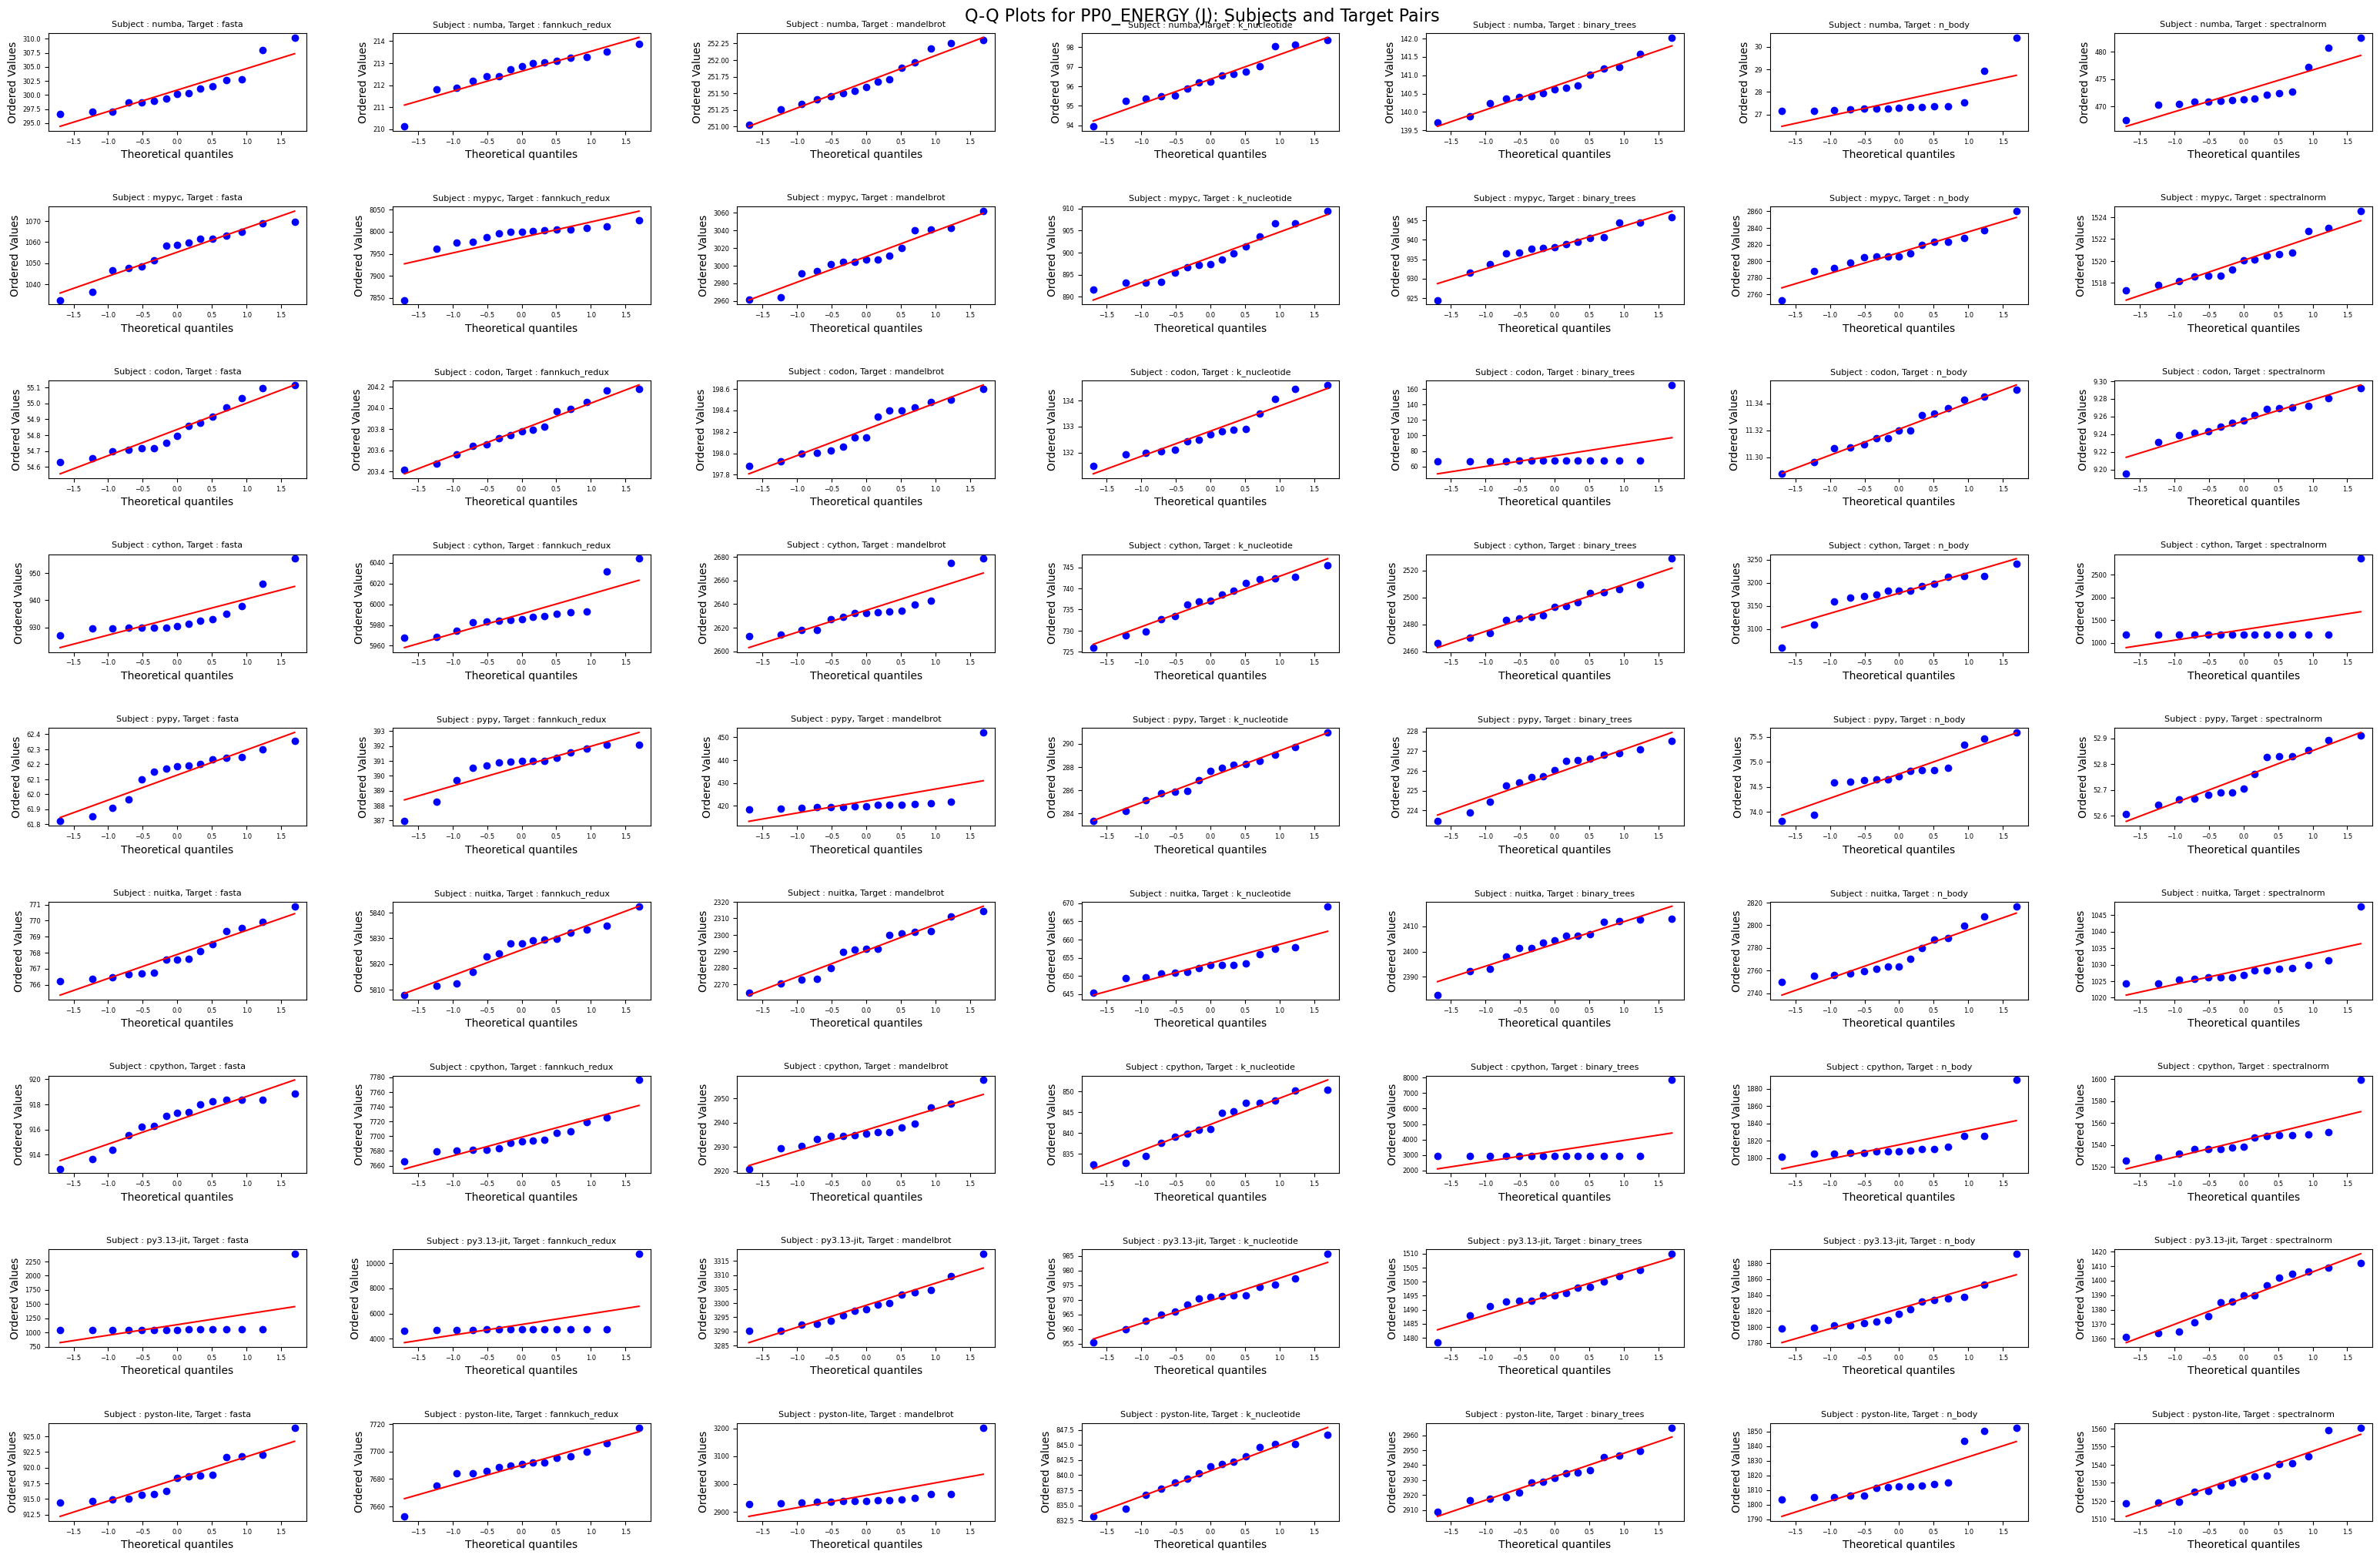

In [9]:
def plot_qq_grid(df : pd.DataFrame, metric, dist='norm', figsize=(32, 21)):

    # Create the figure and axes
    fig, axes = plt.subplots(len(df['subject'].unique()), len(df['target'].unique()), figsize=figsize)
    fig.tight_layout(pad=5.0)

    for row, subject in enumerate(df['subject'].unique()):
        for col, target in enumerate(df['target'].unique()):
            ax = axes[row, col]
            
            # Extract the data for the current subject and target function
            subject_data = df[(df['subject'] == subject) & (df['target'] == target)][metric]

            if len(subject_data) > 0:
                # Generate theoretical quantiles and ordered data
                probplot(subject_data, dist=dist, plot=ax)

                # Add a title for the plot
                ax.set_title(f"Subject : {subject}, Target : {target}", fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=6)

            else:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])

    # Set global labels
    fig.suptitle(f"Q-Q Plots for {metric}: Subjects and Target Pairs", fontsize=16)
    plt.show()

plot_qq_grid(EXPERIMENT, 'PP0_ENERGY (J)')

#### Normality Test: Shapiro-Wilk for each function

In [10]:
def compute_shapiro_wilk_by_target_and_subject(df, metrics, target_column='target', subject_column='subject'):
    results = []
    
    # Group by target and subject
    grouped = df.groupby([subject_column, target_column])
    
    for (subject_name, target_name), group_data in grouped:
        for metric in metrics:
            if metric in group_data.columns:
                # Drop NaN values for the current column within the group
                values = group_data[metric].dropna()
                
                if len(values) > 2:  # Shapiro-Wilk requires at least 3 data points
                    w_stat, p_value = shapiro(values)
                    results.append({
                        'subject': subject_name,
                        'target': target_name,
                        'metric': metric,
                        'w-stat': w_stat,
                        'p-value': p_value,
                        'normality': True if p_value > NORMALITY_ALPHA else False
                    })
                else:
                    results.append({
                        'subject': subject_name,
                        'target': target_name,
                        'metric': metric,
                        'w-stat': None,
                        'p-value': None,
                        'normality': None
                    })
            else:
                results.append({
                    'subject': subject_name,
                    'target': target_name,
                    'metric': metric,
                    'w-stat': None,
                    'p-value': None,
                    'normality': None
                })
    
    return pd.DataFrame(results)

# Example usage
metrics_to_test = [
    'PP0_ENERGY (J)', 'DRAM_ENERGY (J)', 'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY', 'execution_time', 
    'cache-references', 'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores', 'LLC-store-misses'
]

NORMALITY_DATA = compute_shapiro_wilk_by_target_and_subject(EXPERIMENT, metrics_to_test)
print(NORMALITY_DATA)

         subject        target                  metric    w-stat  \
0          codon  binary_trees          PP0_ENERGY (J)  0.296393   
1          codon  binary_trees         DRAM_ENERGY (J)  1.000000   
2          codon  binary_trees          PROCESS_MEMORY  0.650725   
3          codon  binary_trees  PROCESS_VIRTUAL_MEMORY  0.661712   
4          codon  binary_trees          execution_time  0.775799   
..           ...           ...                     ...       ...   
688  pyston-lite  spectralnorm            cache-misses  0.884329   
689  pyston-lite  spectralnorm               LLC-loads  0.951570   
690  pyston-lite  spectralnorm         LLC-load-misses  0.946054   
691  pyston-lite  spectralnorm              LLC-stores  0.796622   
692  pyston-lite  spectralnorm        LLC-store-misses  0.850865   

          p-value normality  
0    1.181300e-07     False  
1    1.000000e+00      True  
2    7.743444e-05     False  
3    9.964445e-05     False  
4    1.828351e-03     False  
.. 

/home/xeder/anaconda3/envs/jss-haddock/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


#### ANOVA (normal) and Kruskal-Wallis (non-normal)

In [6]:
def compute_anova_test(df : pd.DataFrame, target, metric):
    # Group the data by the group column and extract the metric values
    grouped_data = [group[group['target'] == target][metric].values for _, group in df.groupby('subject')]

    # Perform one-way ANOVA
    f_stat, p_value = f_oneway(*grouped_data)

    if p_value < NORMALITY_ALPHA:
        print(f"For {target}, compilers perform DIFFERNTLY in terms of {metric}. (Anova)")
    else:
        print(f"For {target}, compilers perform THE SAME in terms of {metric}. (Anova)")

    return f_stat, p_value


def compute_kruskal_wallis_test(EXPERIMENT: pd.DataFrame, target, metric):
    # Group the data by the 'subject' column and extract the metric values for the specific target
    grouped_data = [group[group['target'] == target][metric].values for _, group in EXPERIMENT.groupby('subject')]

    # Perform Kruskal-Wallis H-test
    h_stat, p_value = kruskal(*grouped_data)

    if p_value < NORMALITY_ALPHA:
        print(f"For {target}, compilers perform DIFFERENTLY in terms of {metric} (Kruskal-Wallis).")
    else:
        print(f"For {target}, compilers perform THE SAME in terms of {metric} (Kruskal-Wallis).")

    return h_stat, p_value


metrics_to_test = ['PP0_ENERGY (J)', 'DRAM_ENERGY (J)', 'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY', 'execution_time', 
    'cache-references', 'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores', 'LLC-store-misses']
targets_to_test = ['mandelbrot', 'spectralnorm', 'binary_trees', 'fasta', 'k_nucleotide', 'n_body', 'fannkuch_redux']

for target in targets_to_test:
    for metric in metrics_to_test:
        if NORMALITY_DATA[(NORMALITY_DATA['target'] == target) & (NORMALITY_DATA['metric'] == metric)]['normality'].all():
            compute_anova_test(EXPERIMENT, target, metric)
        else:
            compute_kruskal_wallis_test(EXPERIMENT, target, metric)

For mandelbrot, compilers perform DIFFERENTLY in terms of PP0_ENERGY (J) (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERENTLY in terms of DRAM_ENERGY (J) (Kruskal-Wallis).
For mandelbrot, compilers perform THE SAME in terms of PROCESS_MEMORY (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERENTLY in terms of PROCESS_VIRTUAL_MEMORY (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERENTLY in terms of execution_time (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERENTLY in terms of cache-references (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERENTLY in terms of cache-misses (Kruskal-Wallis).
For mandelbrot, compilers perform DIFFERNTLY in terms of LLC-loads. (Anova)
For mandelbrot, compilers perform DIFFERENTLY in terms of LLC-load-misses (Kruskal-Wallis).
For mandelbrot, compilers perform THE SAME in terms of LLC-stores (Kruskal-Wallis).
For mandelbrot, compilers perform THE SAME in terms of LLC-store-misses (Kruskal-Wallis).
For spectralnor

### Data Visualization

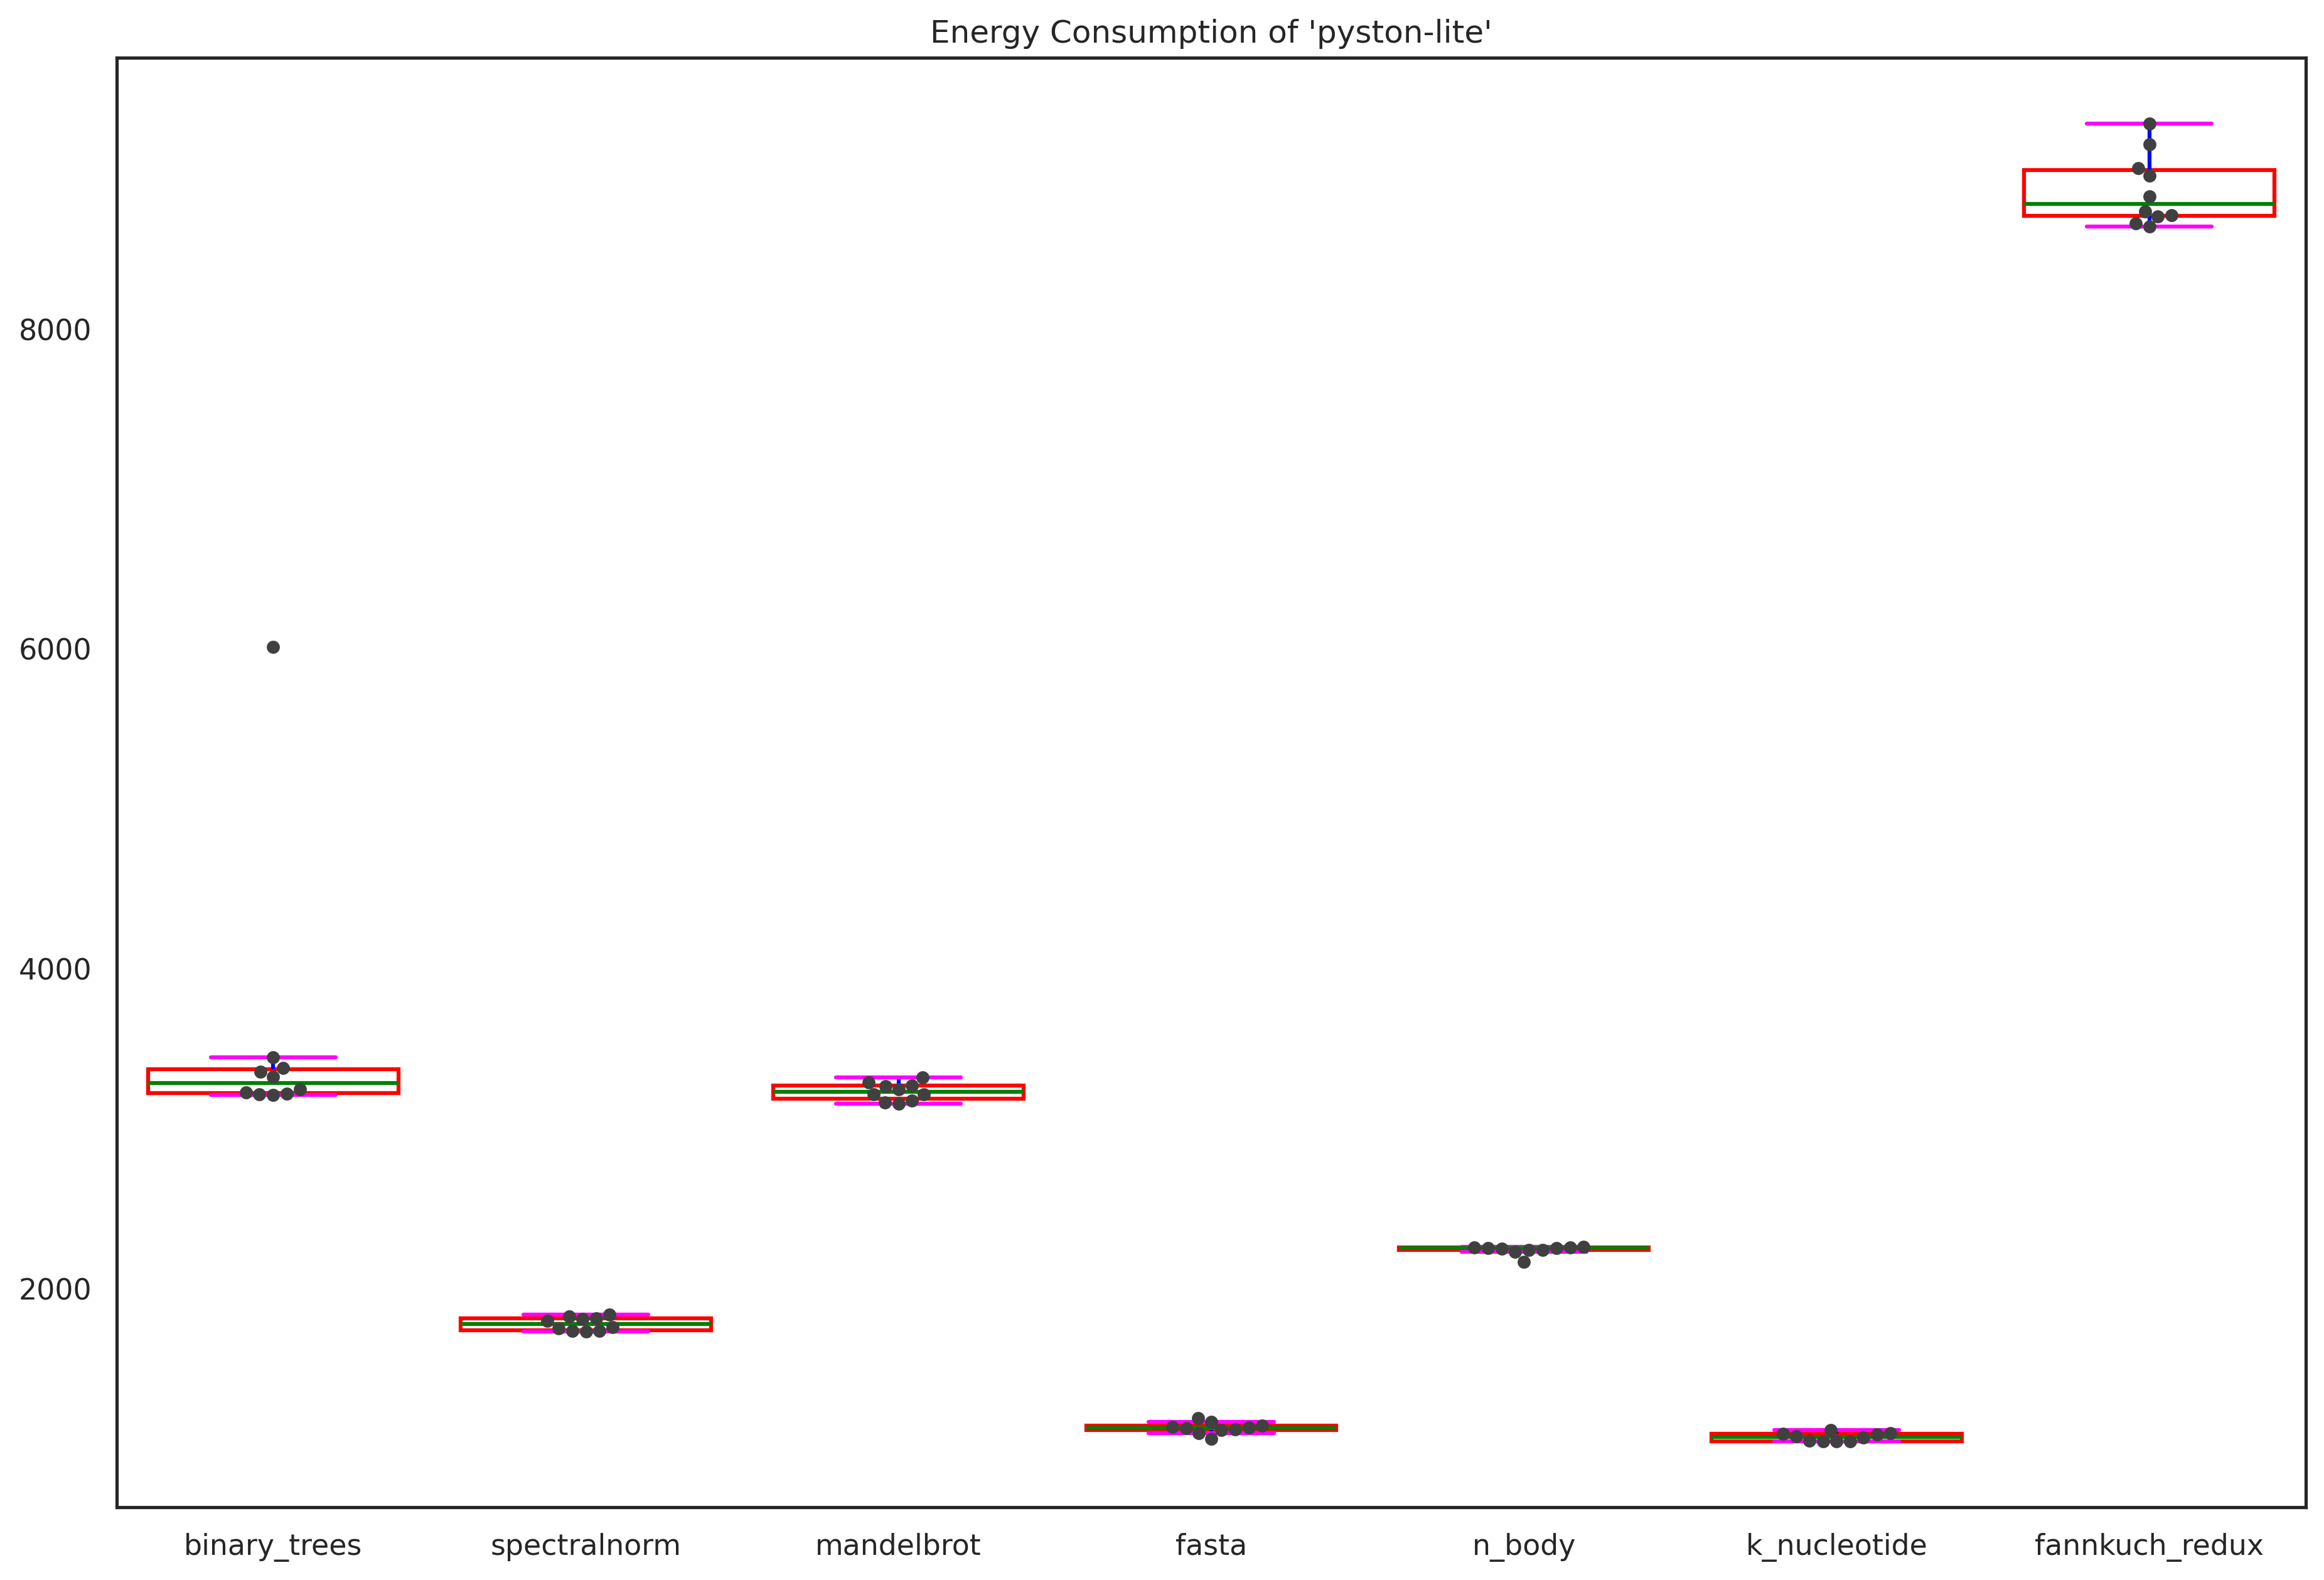

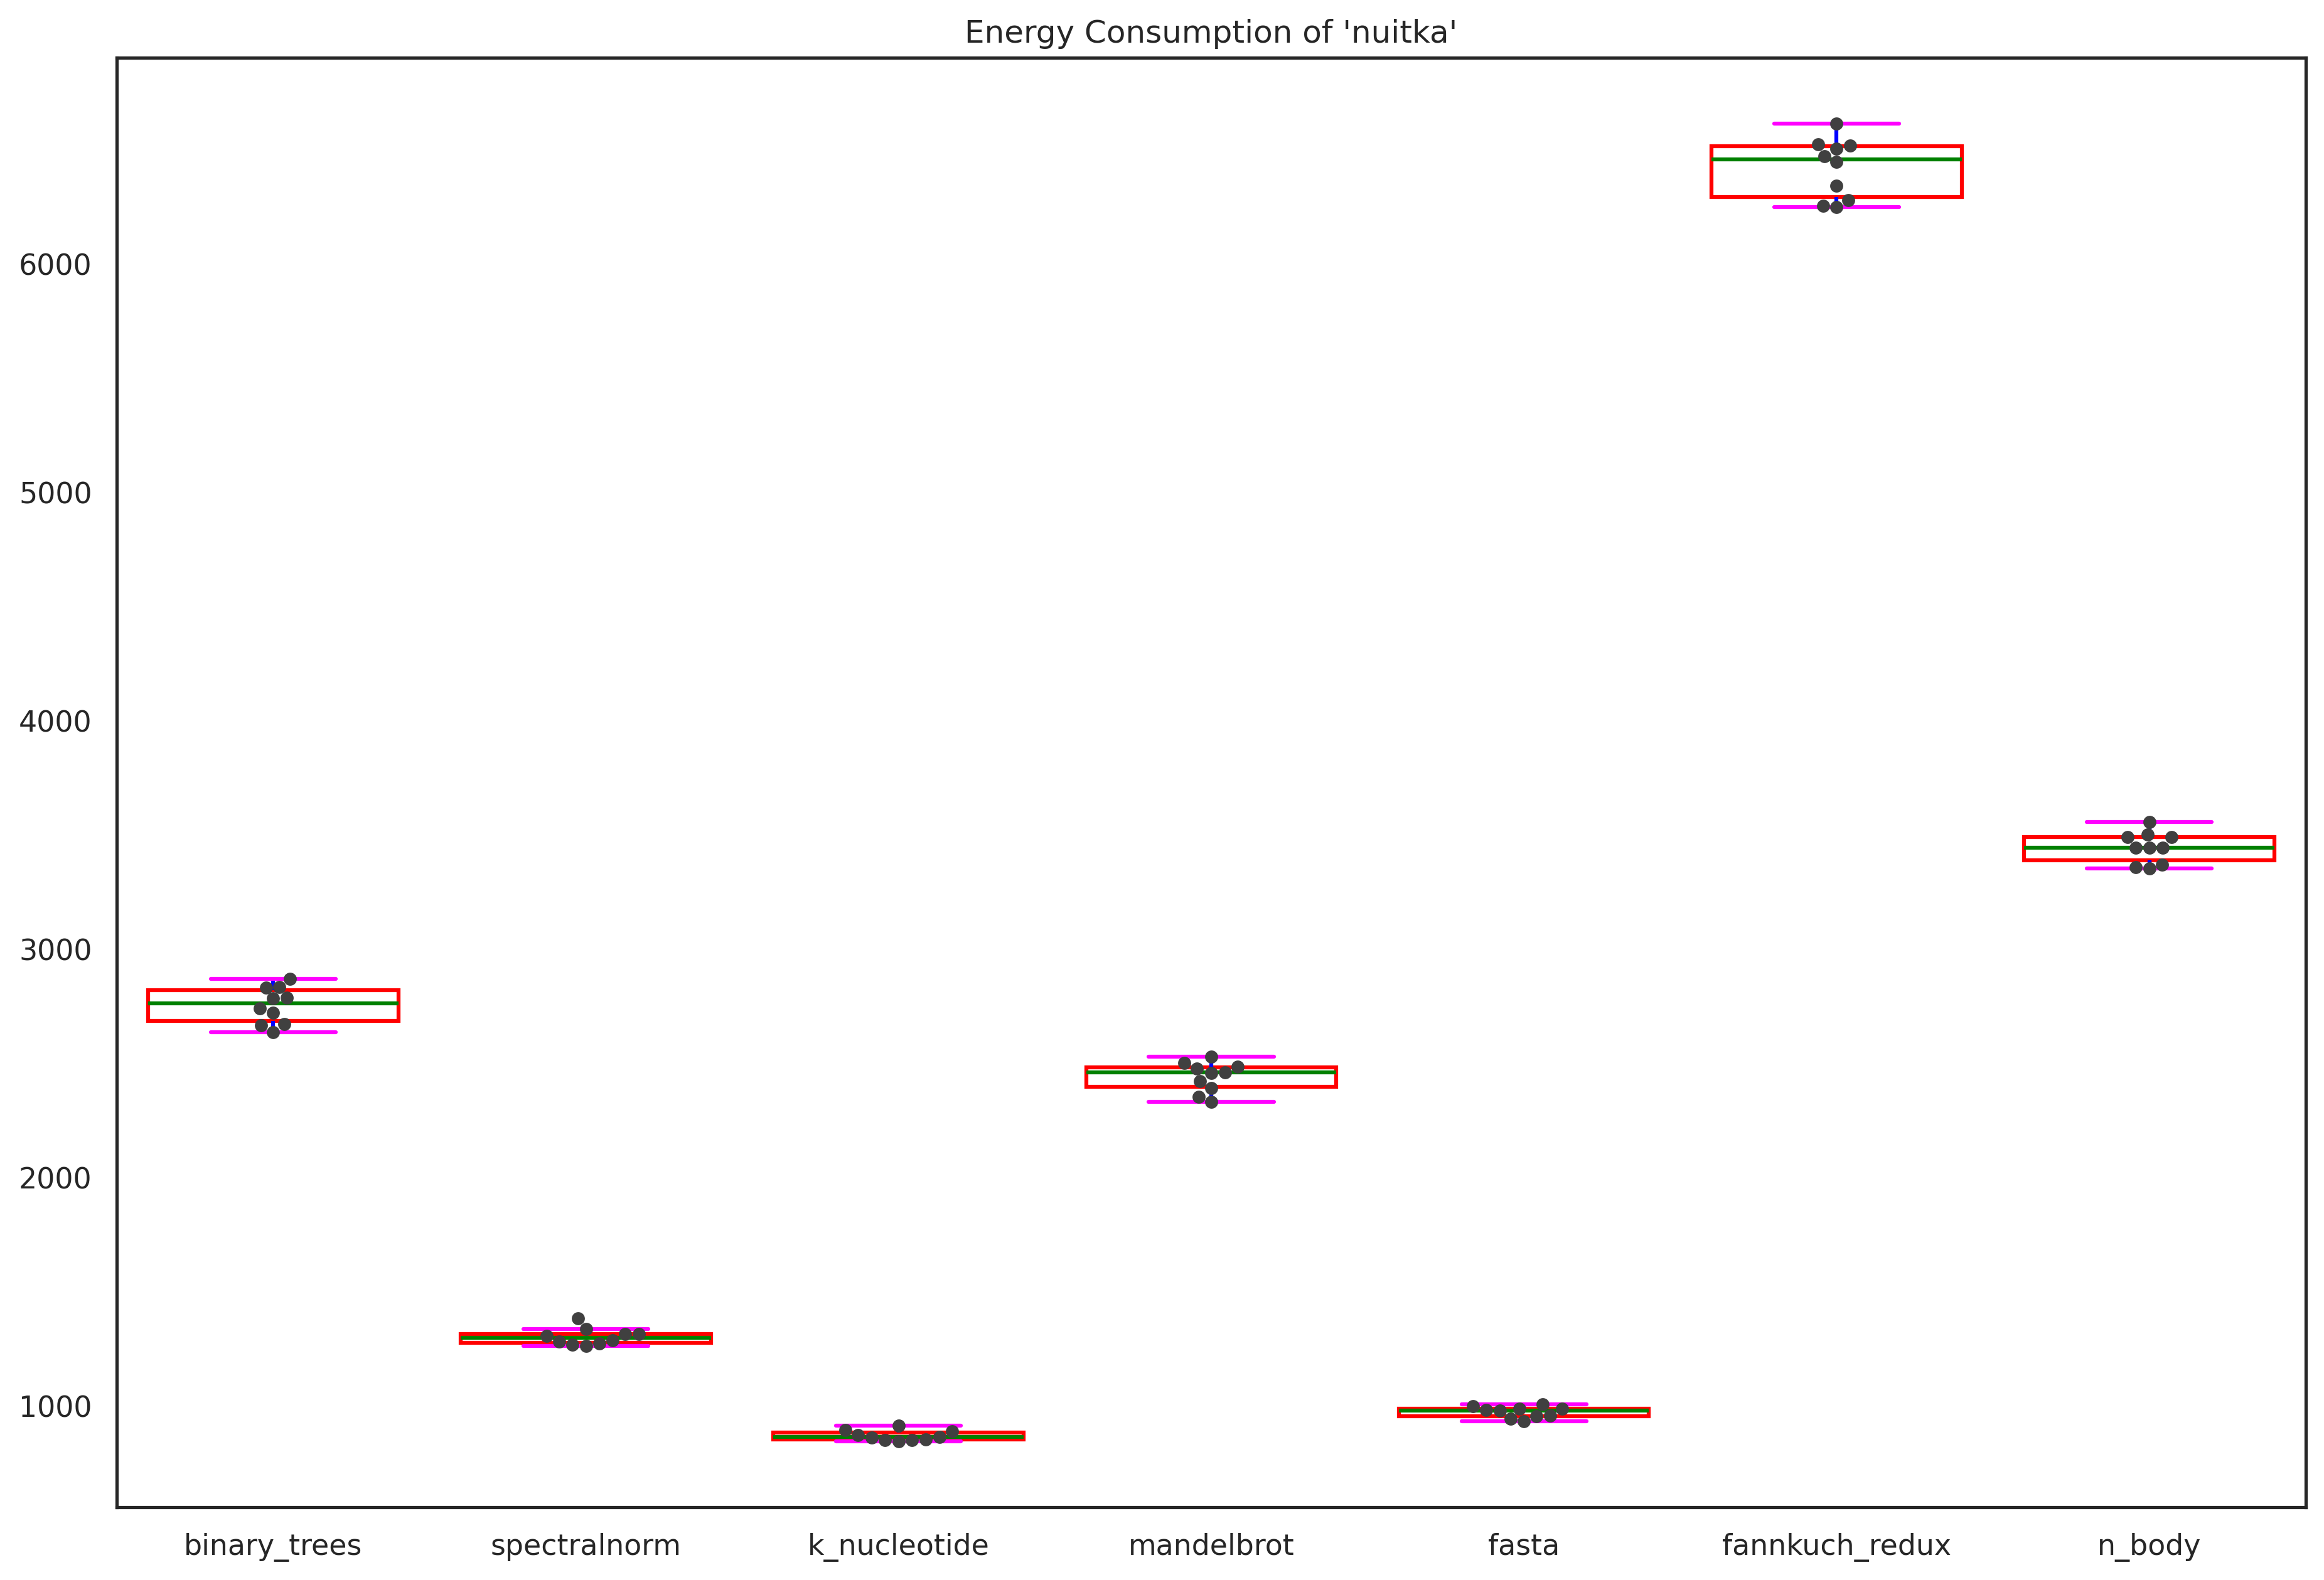

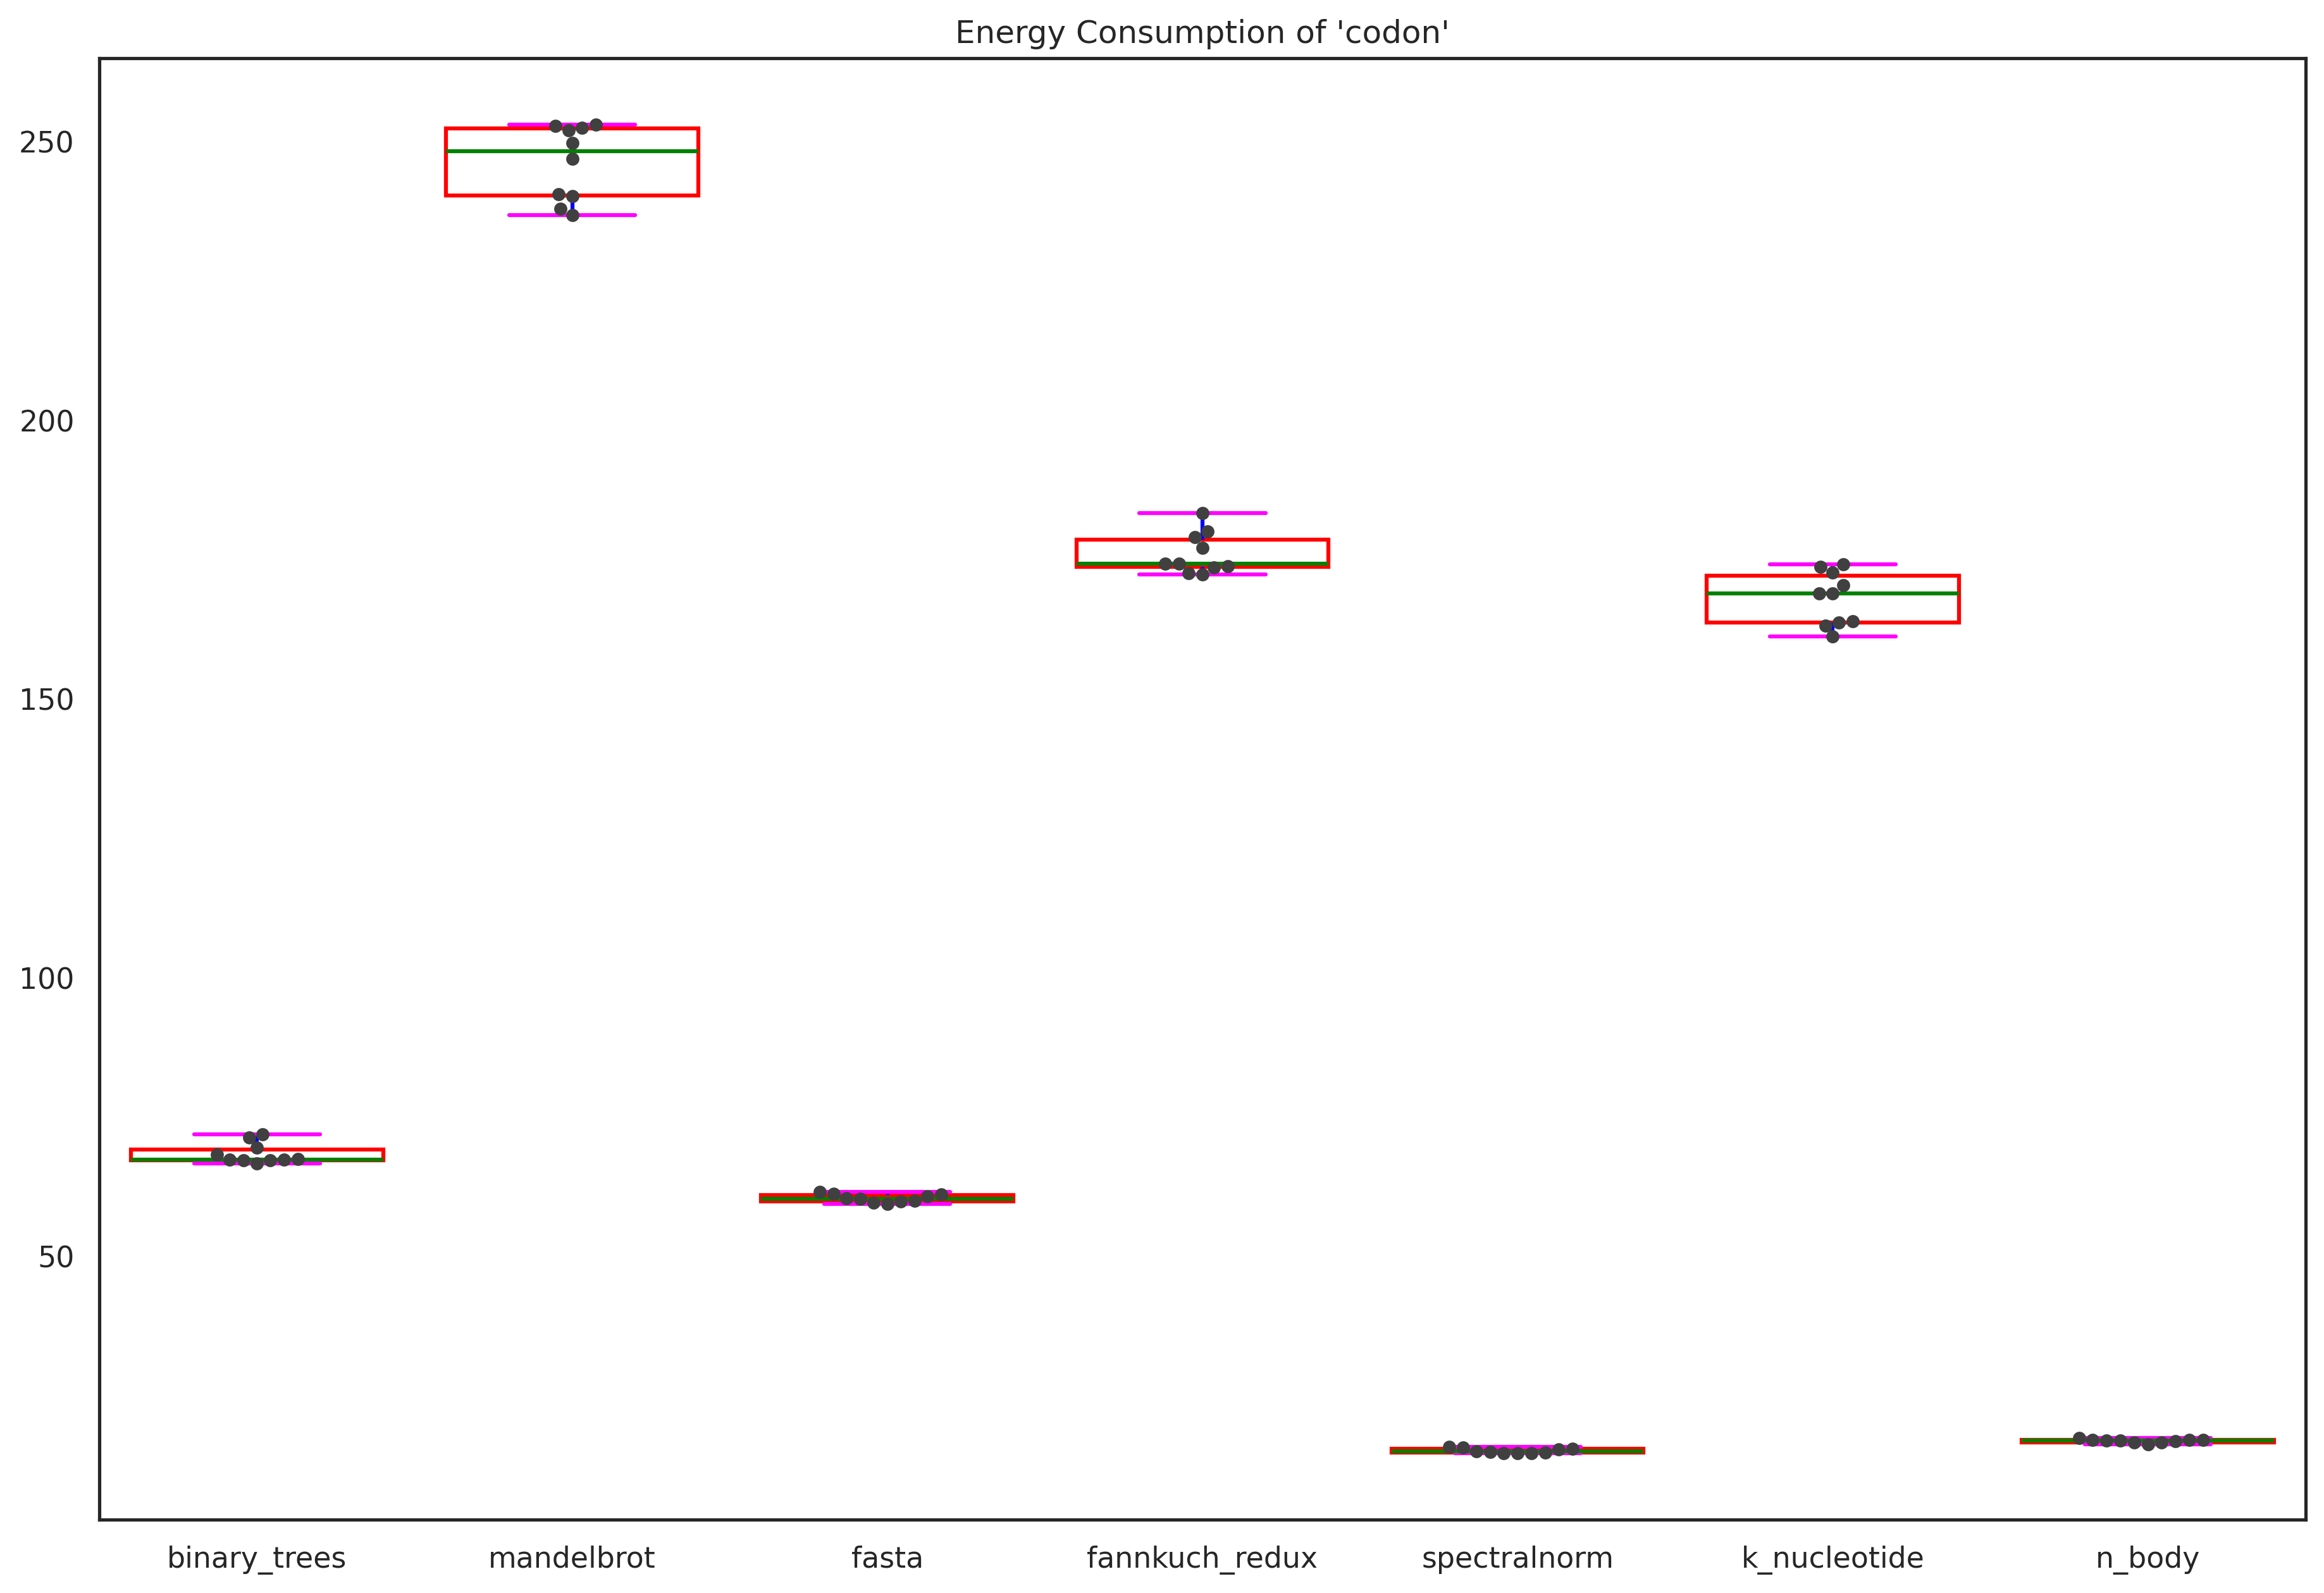

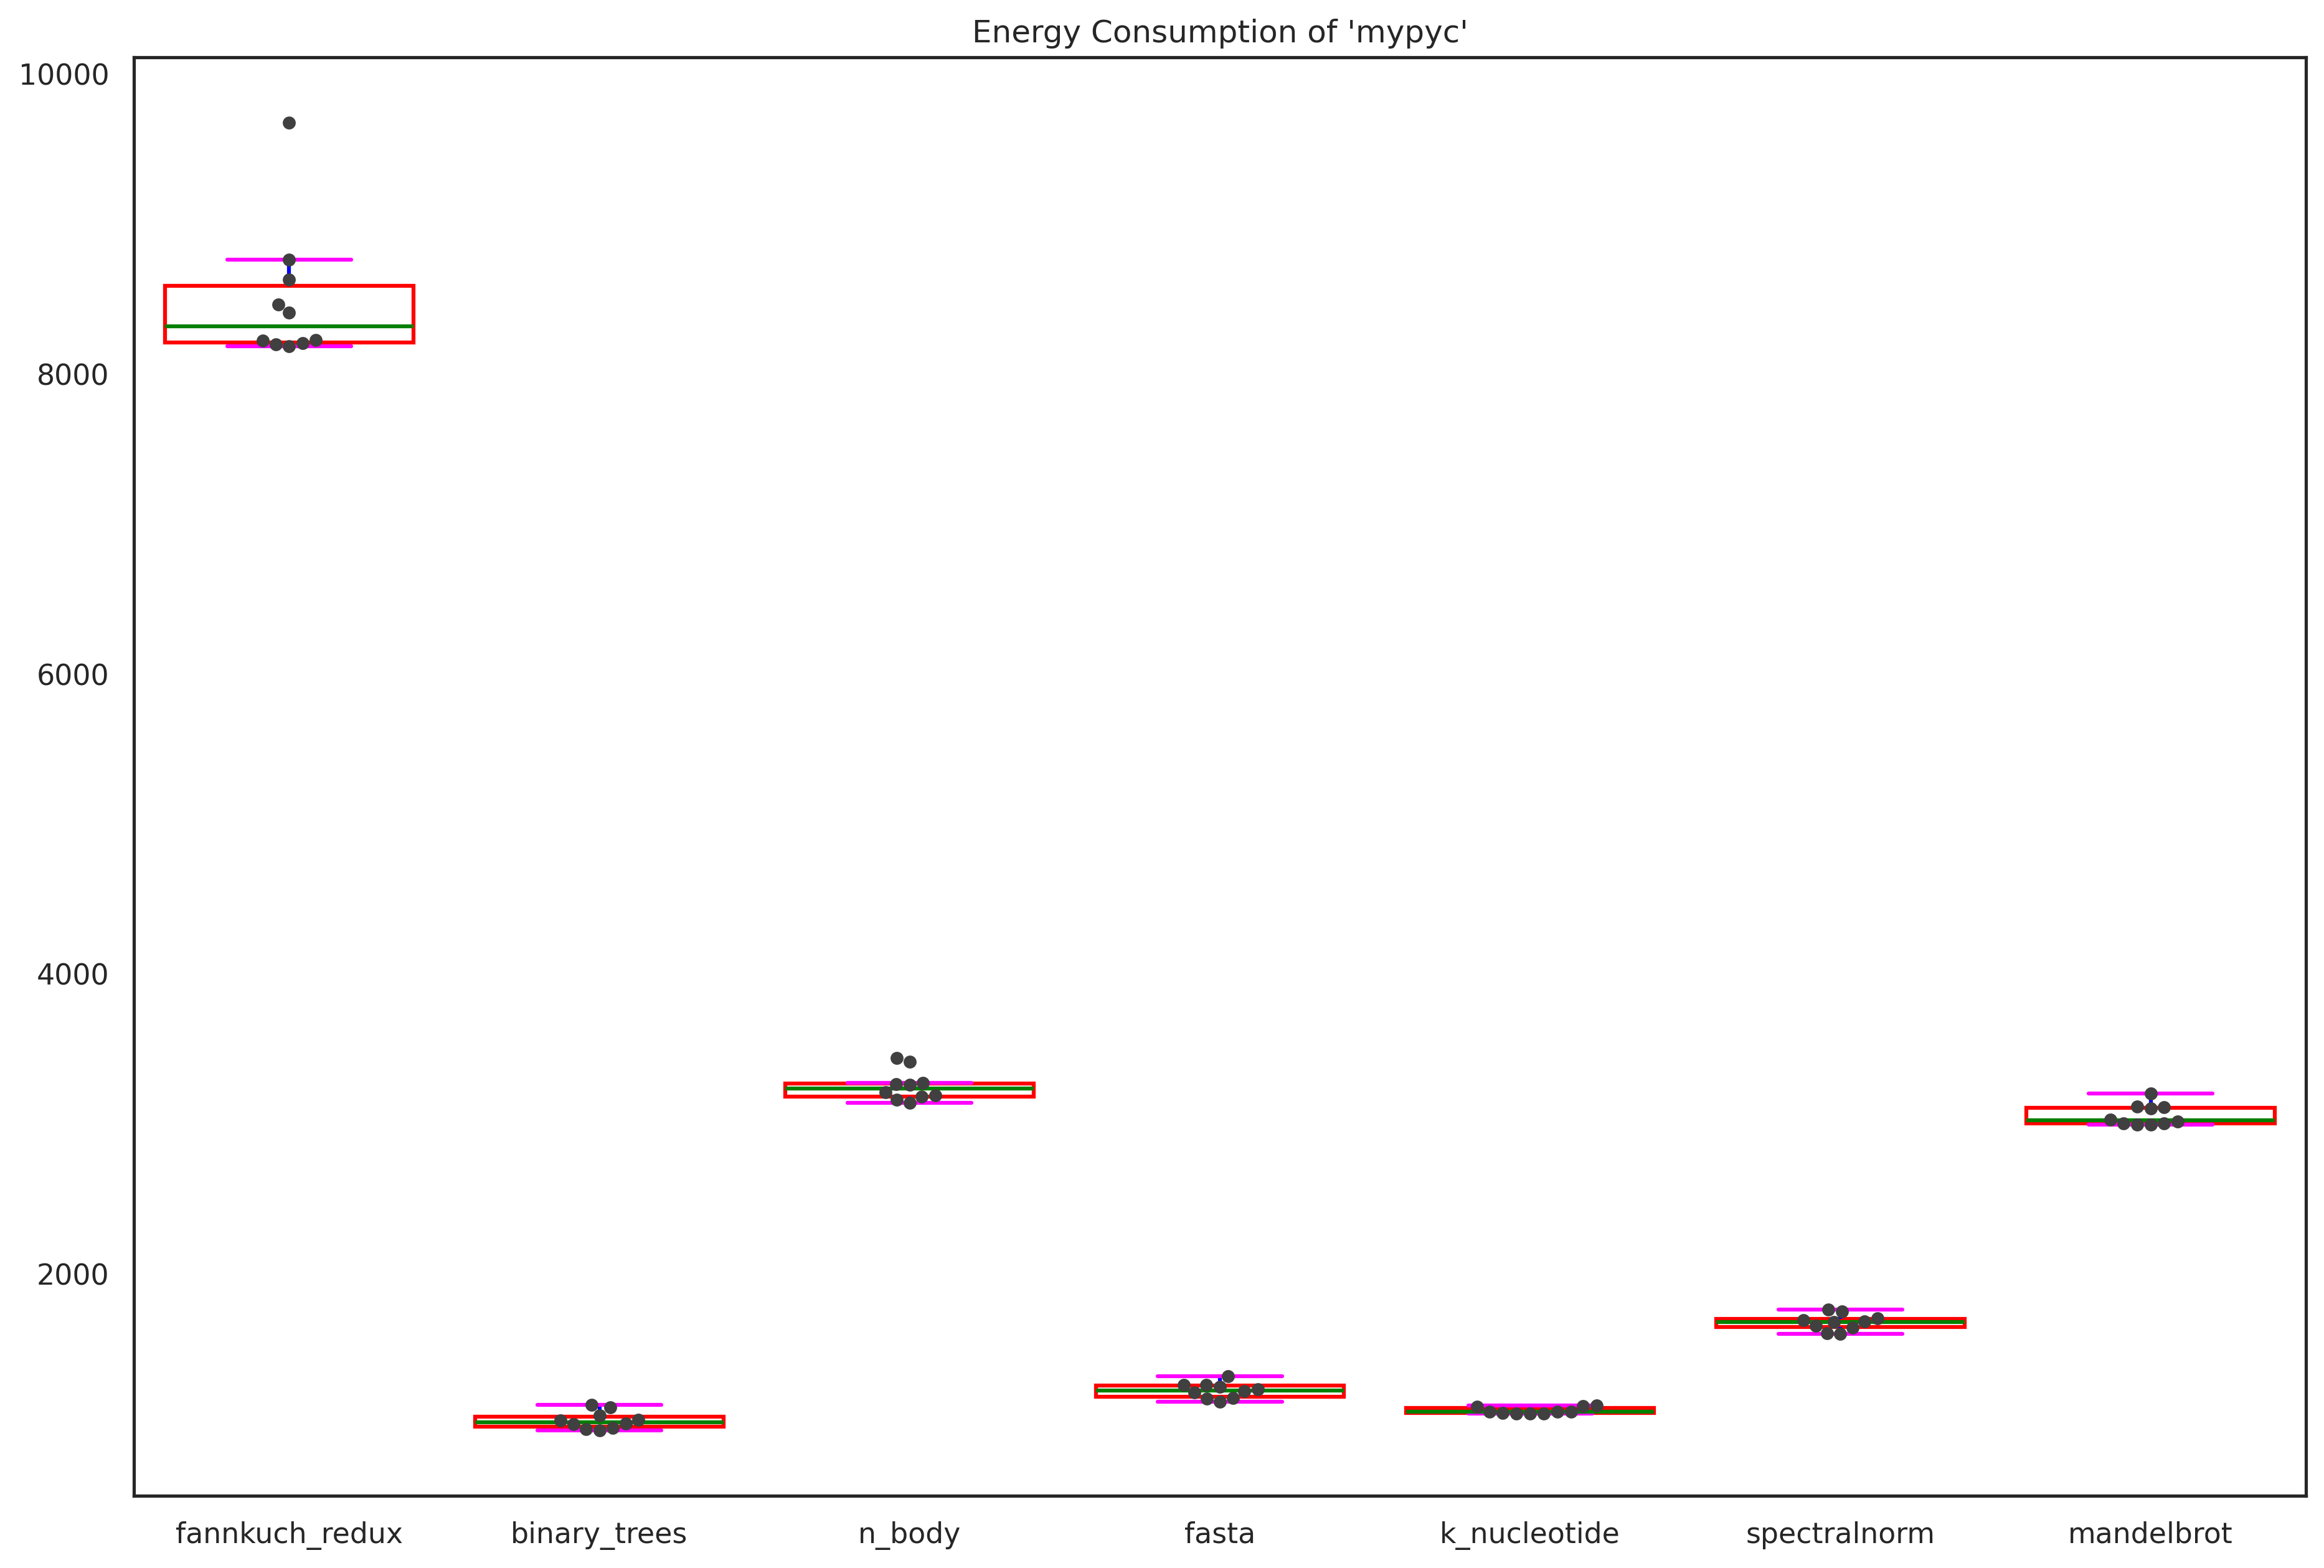

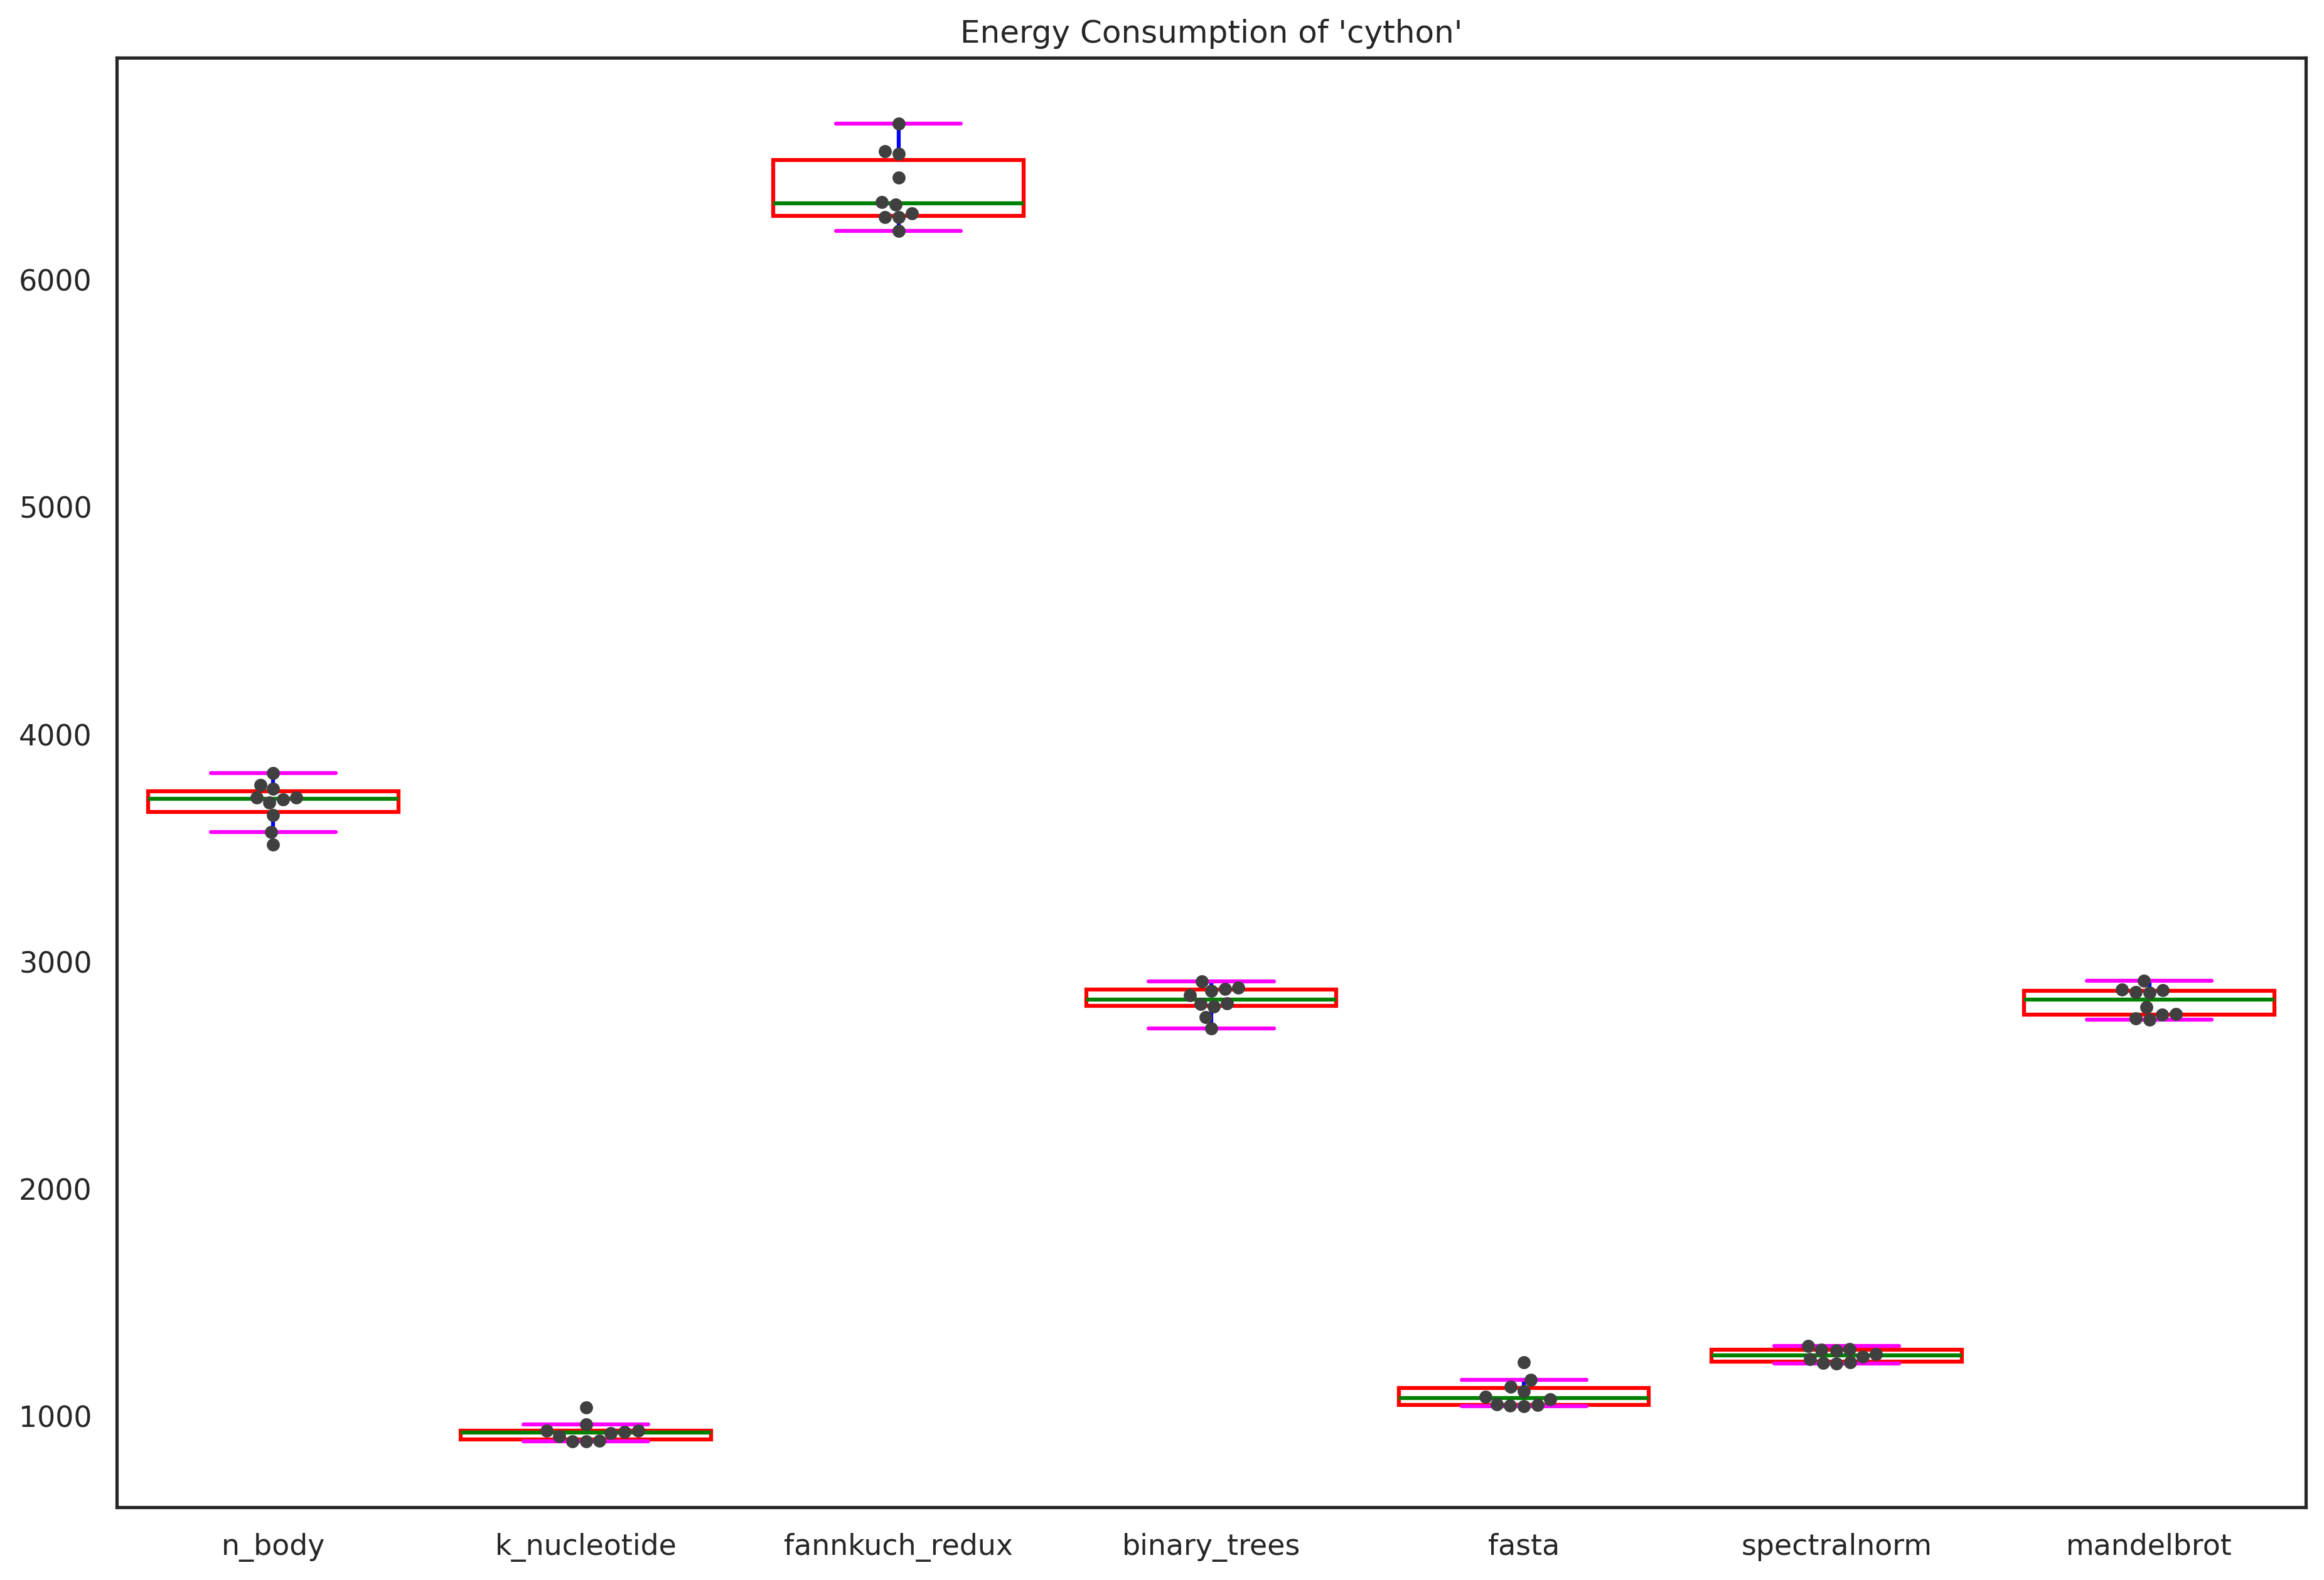

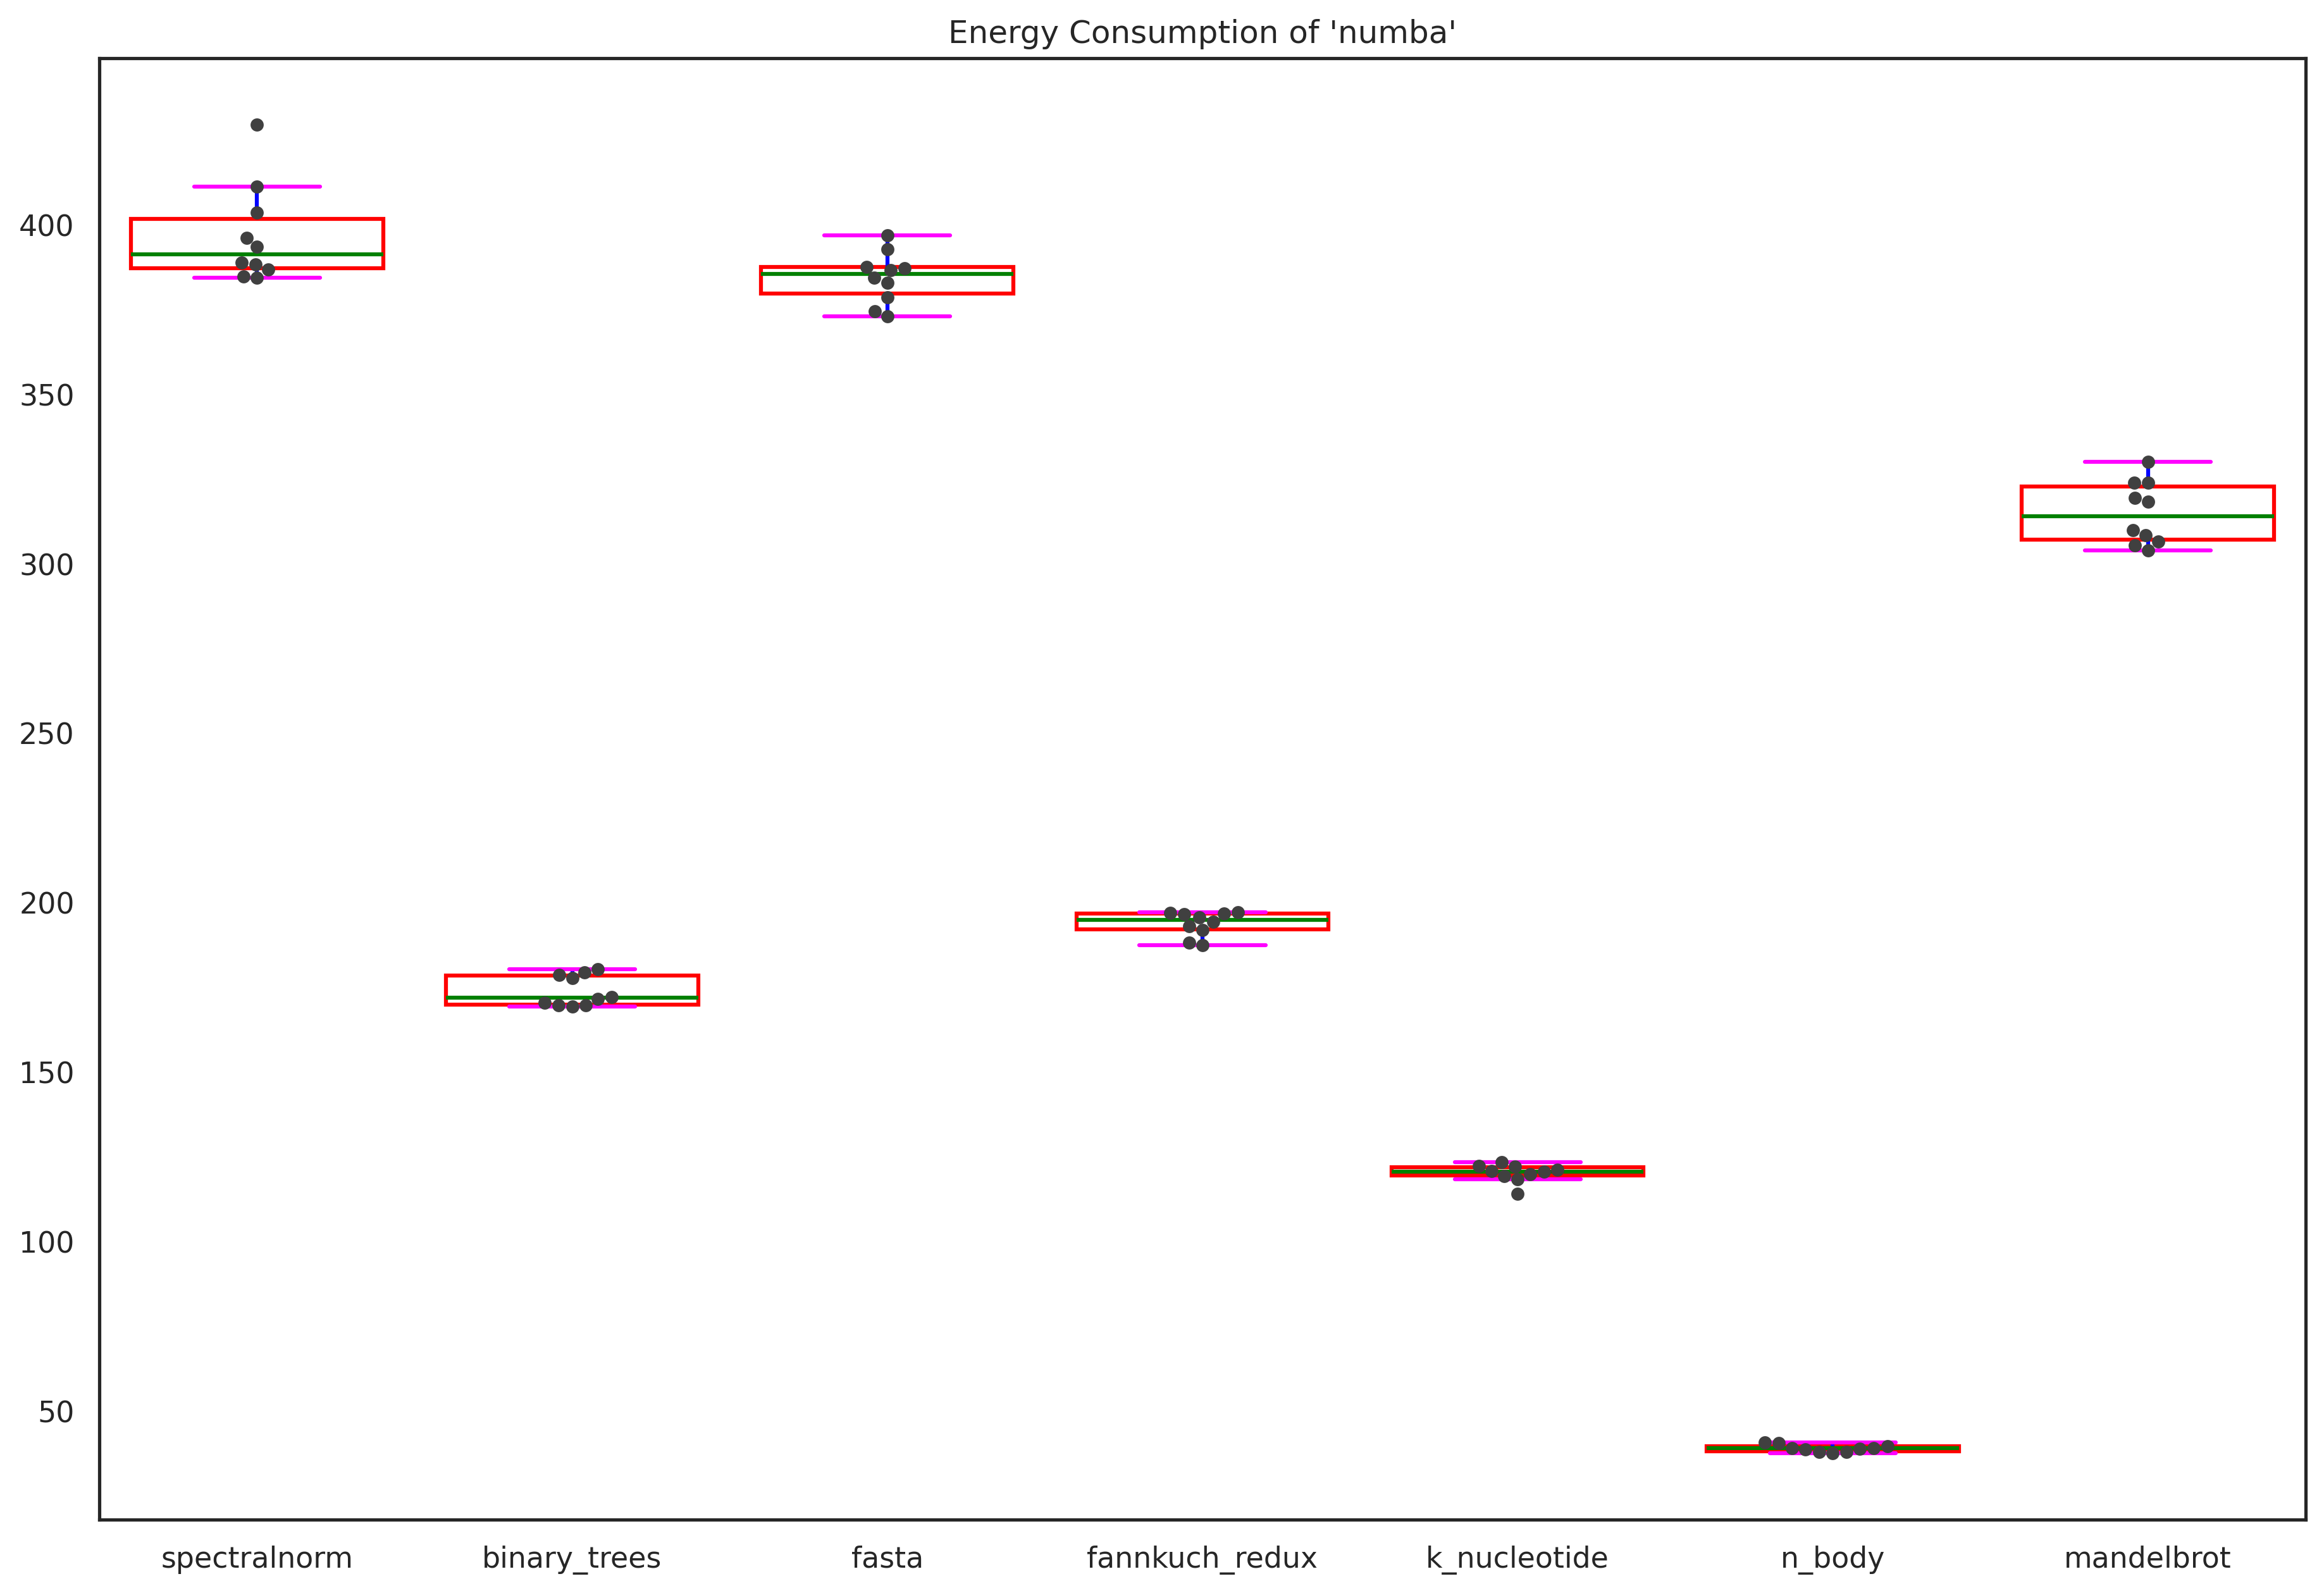

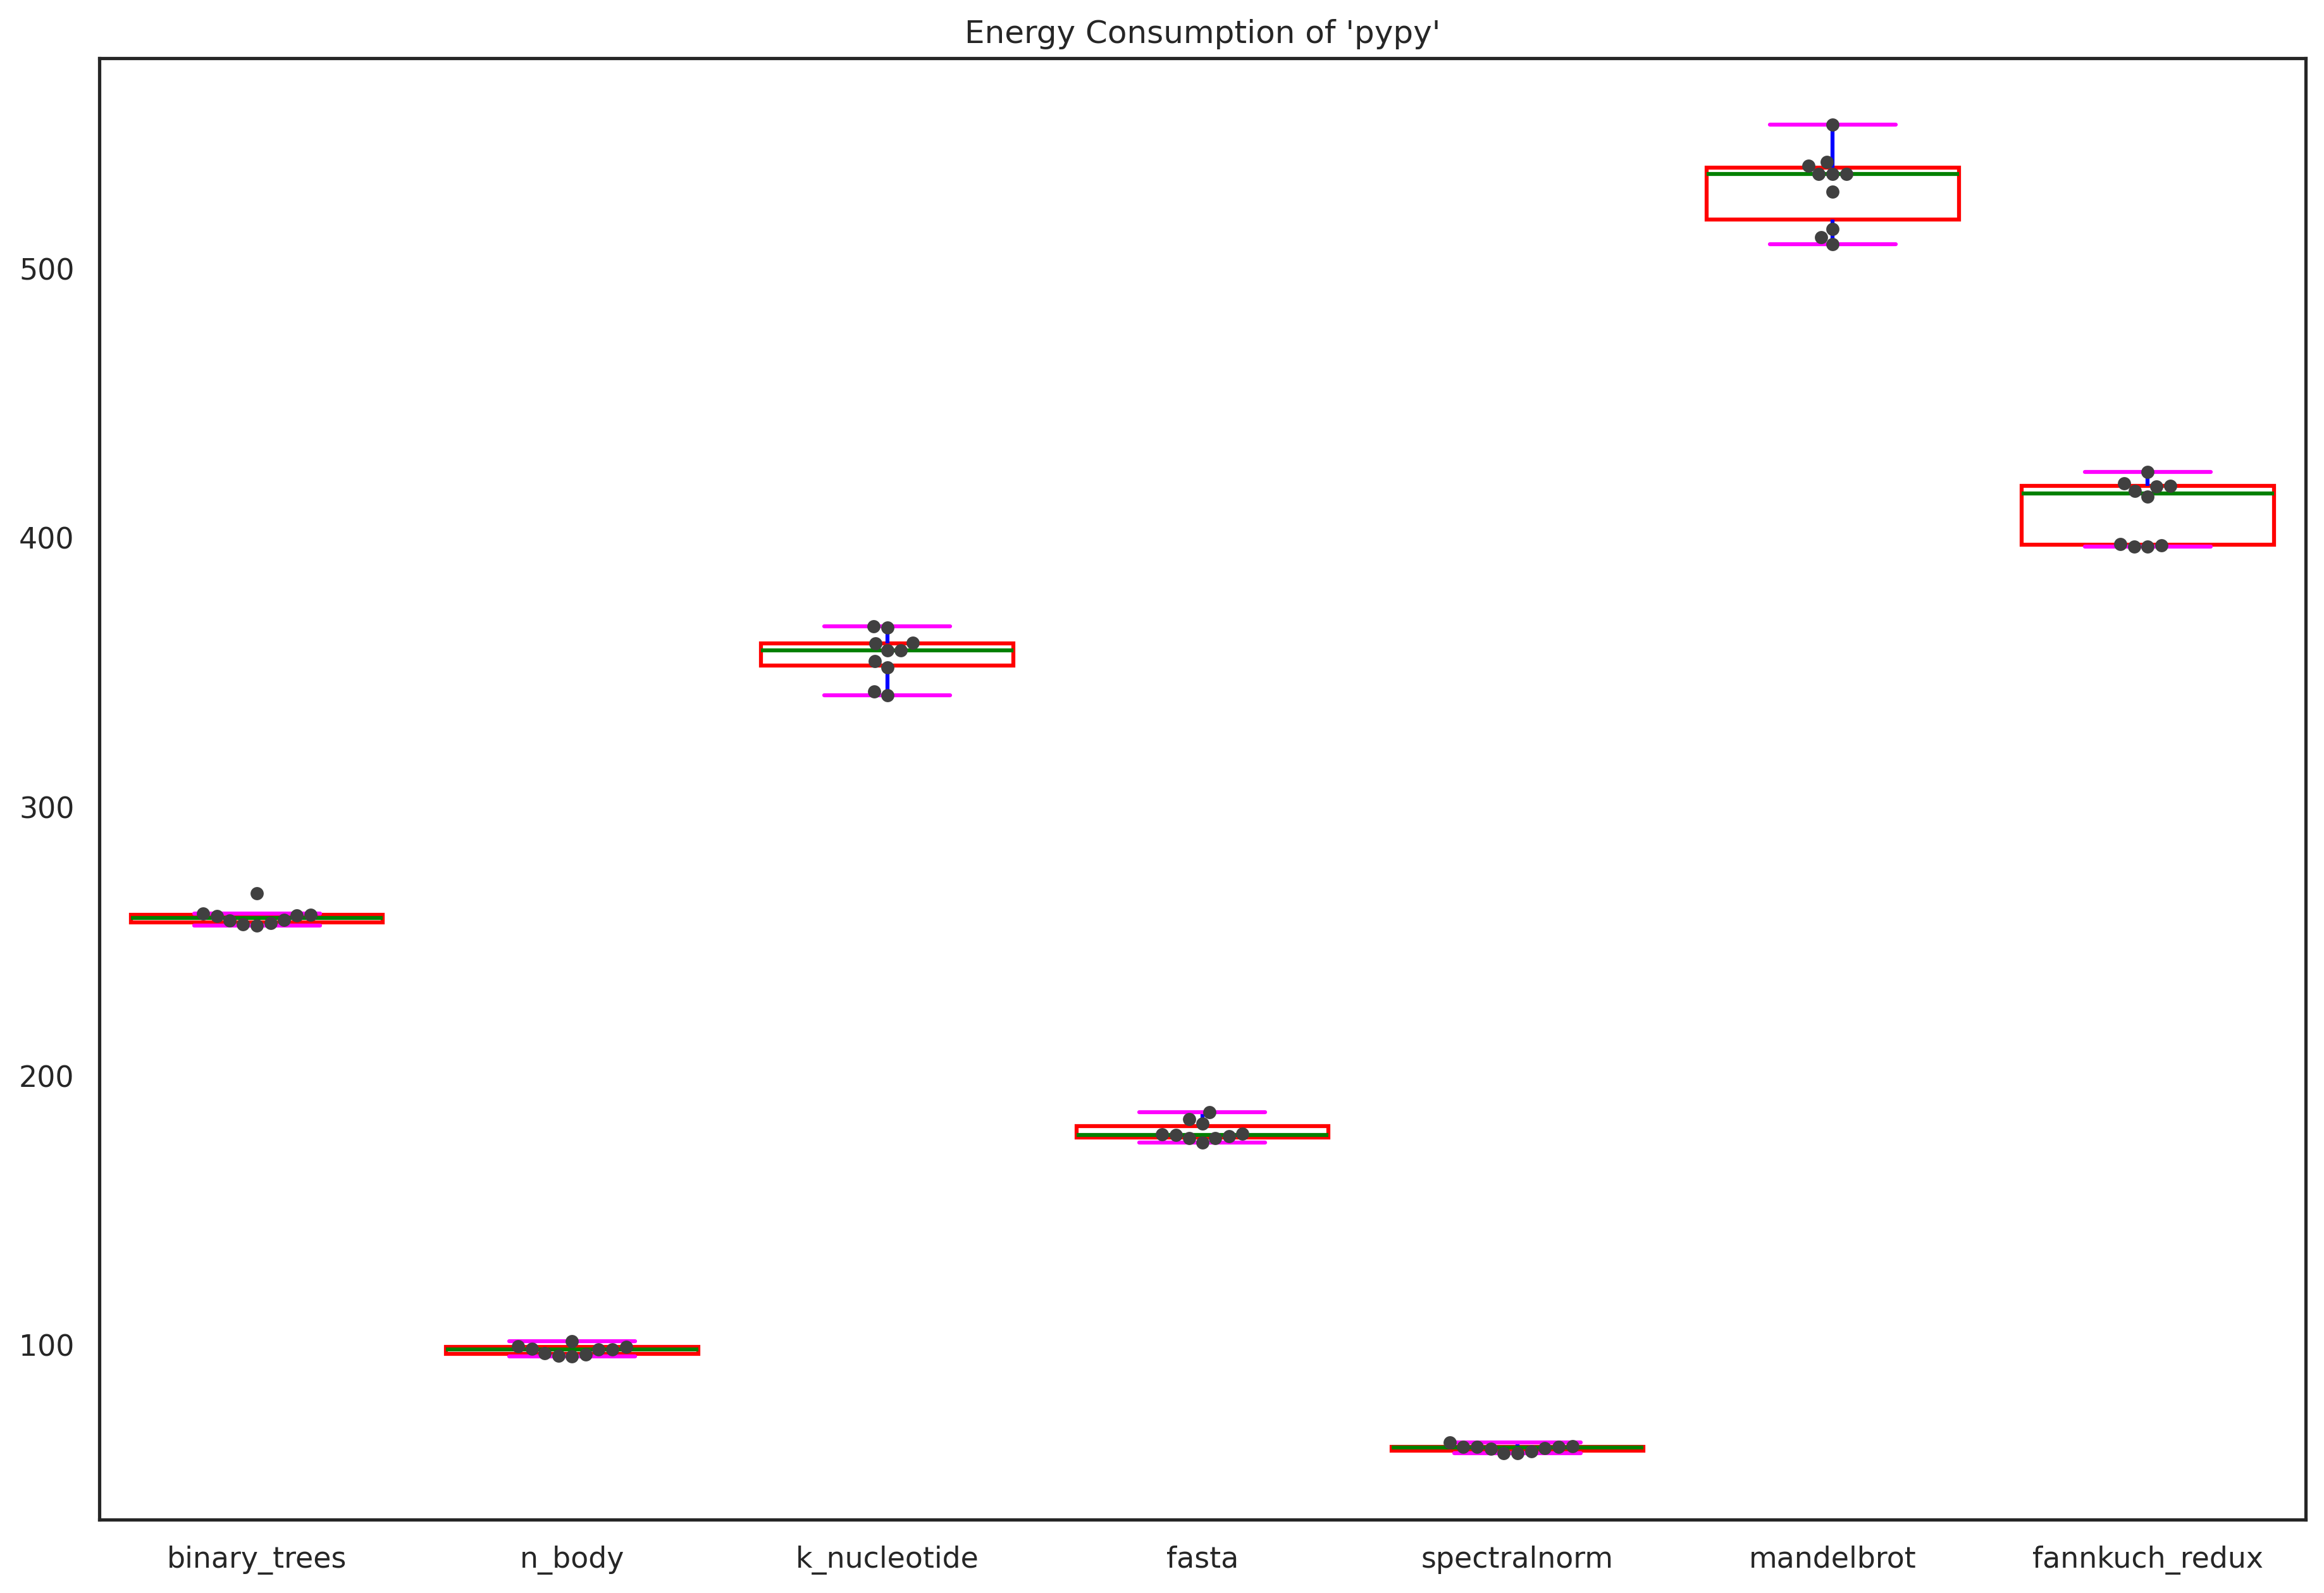

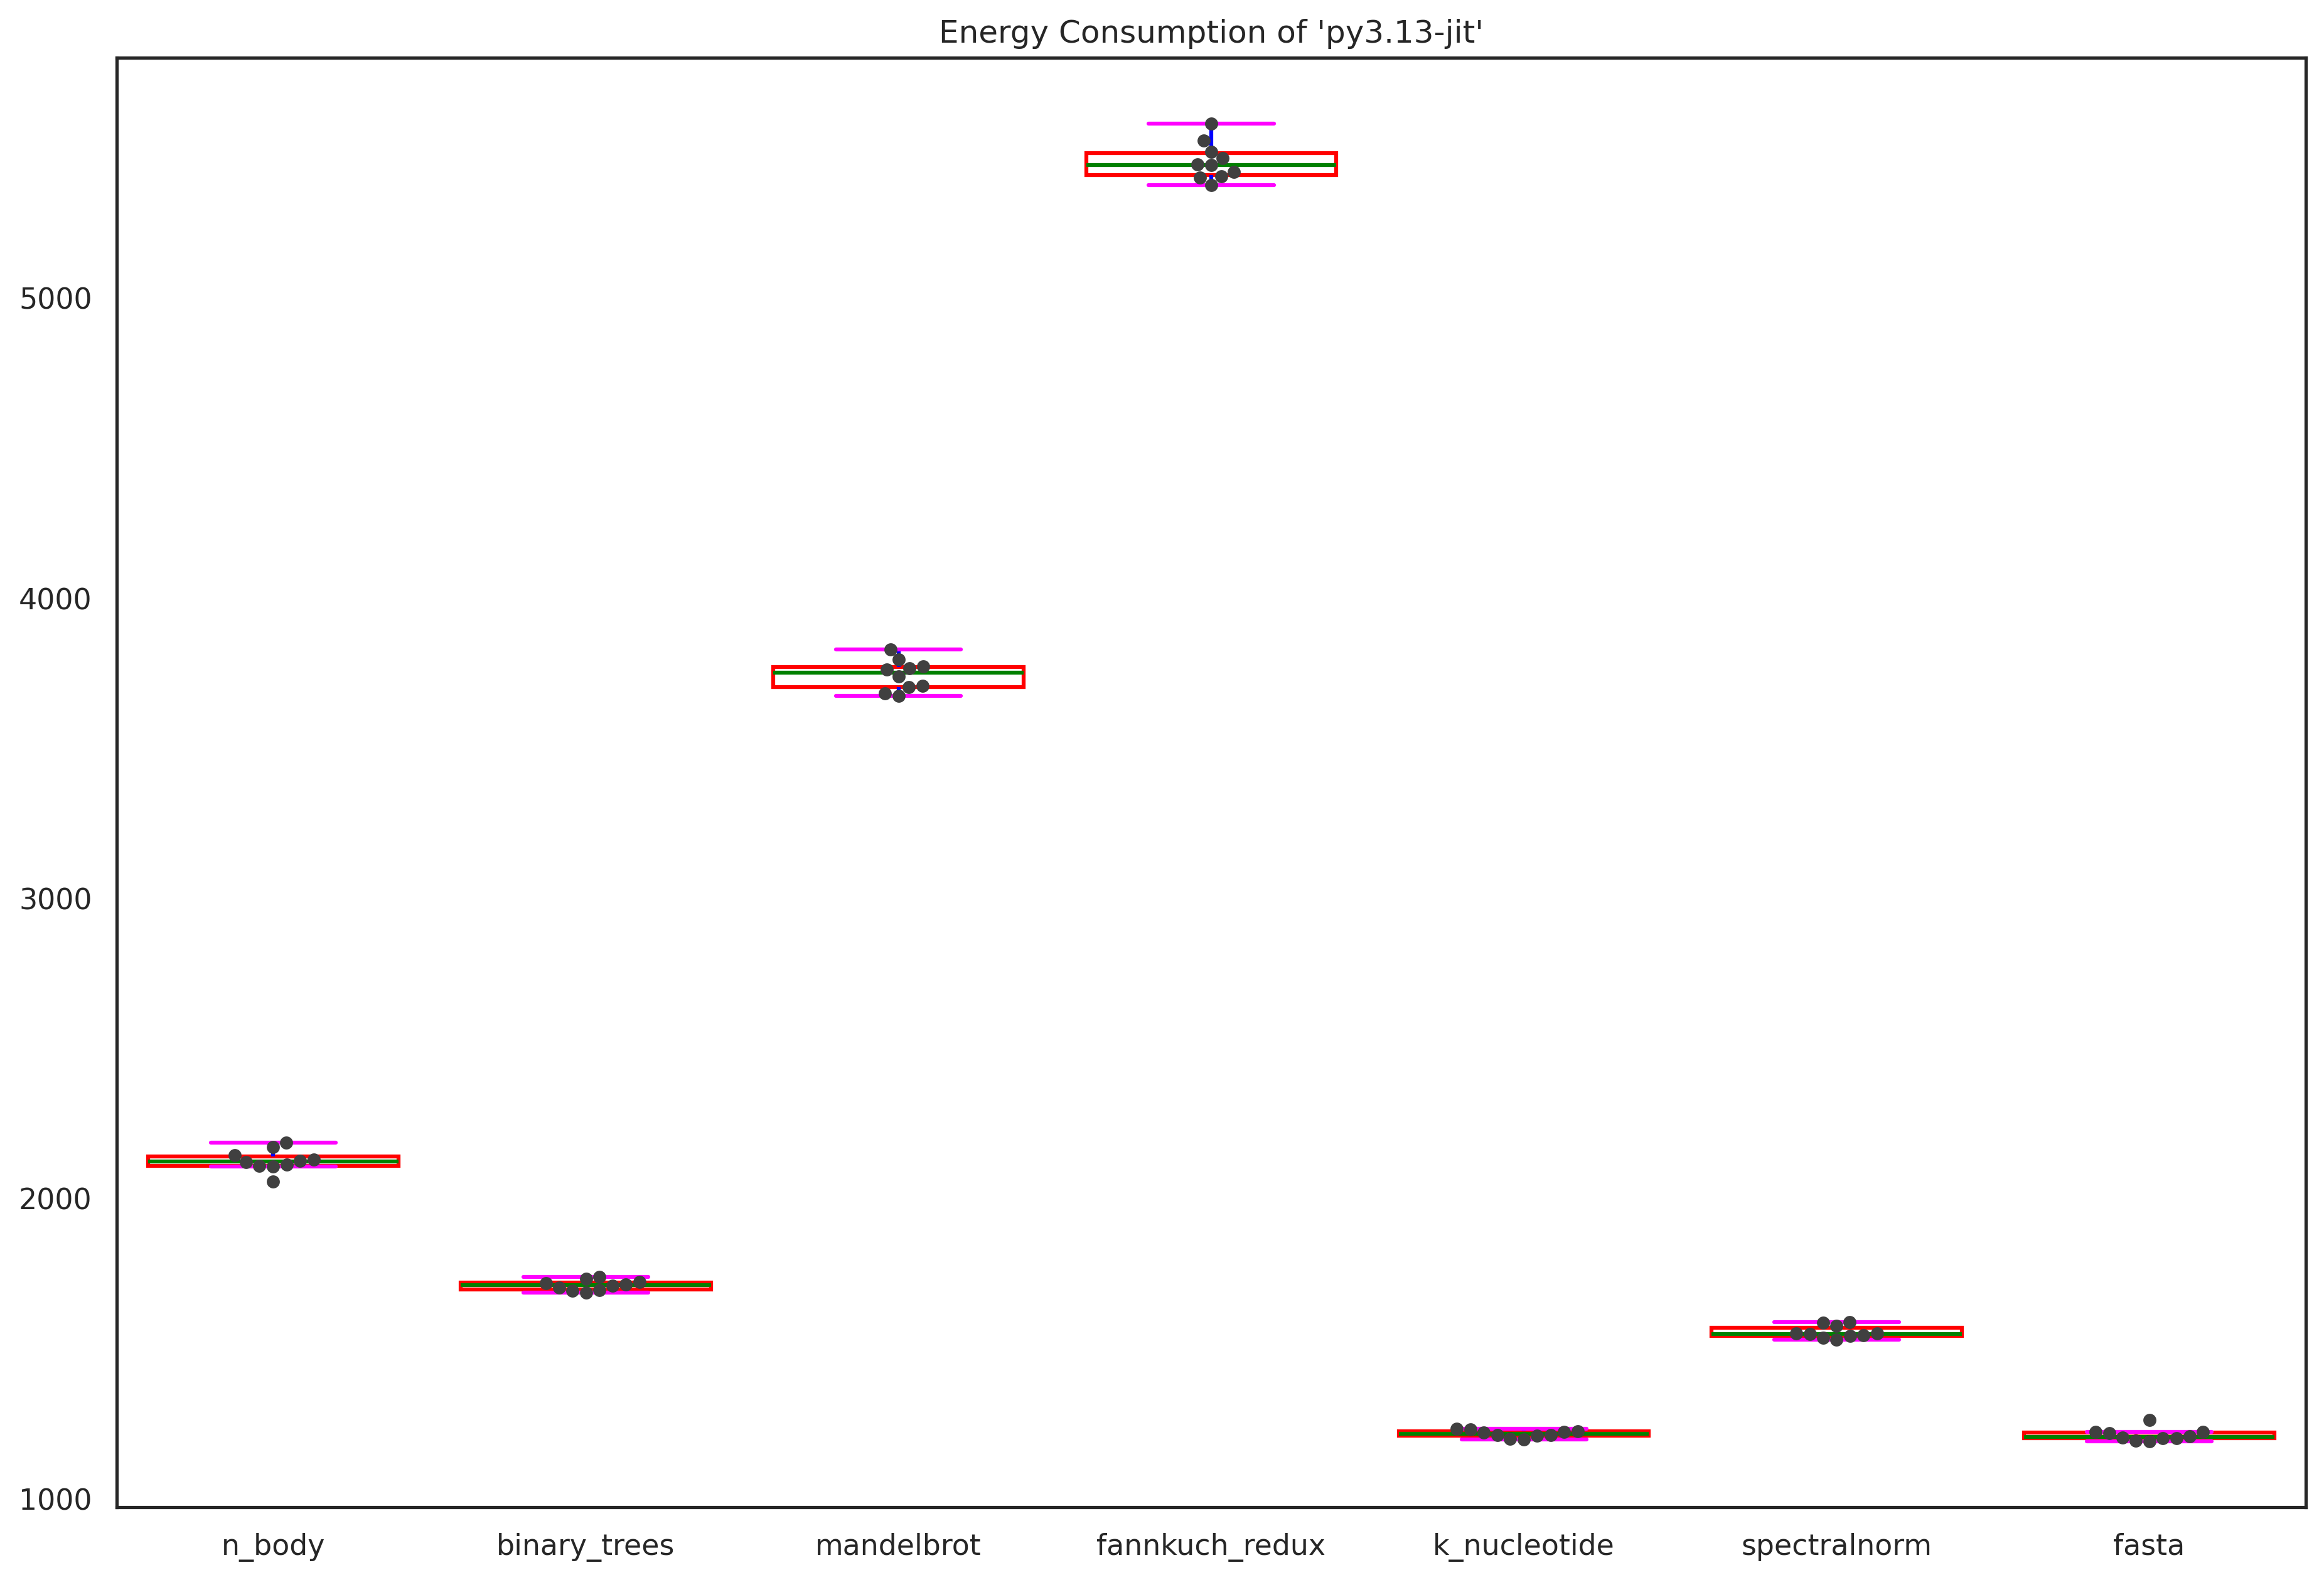

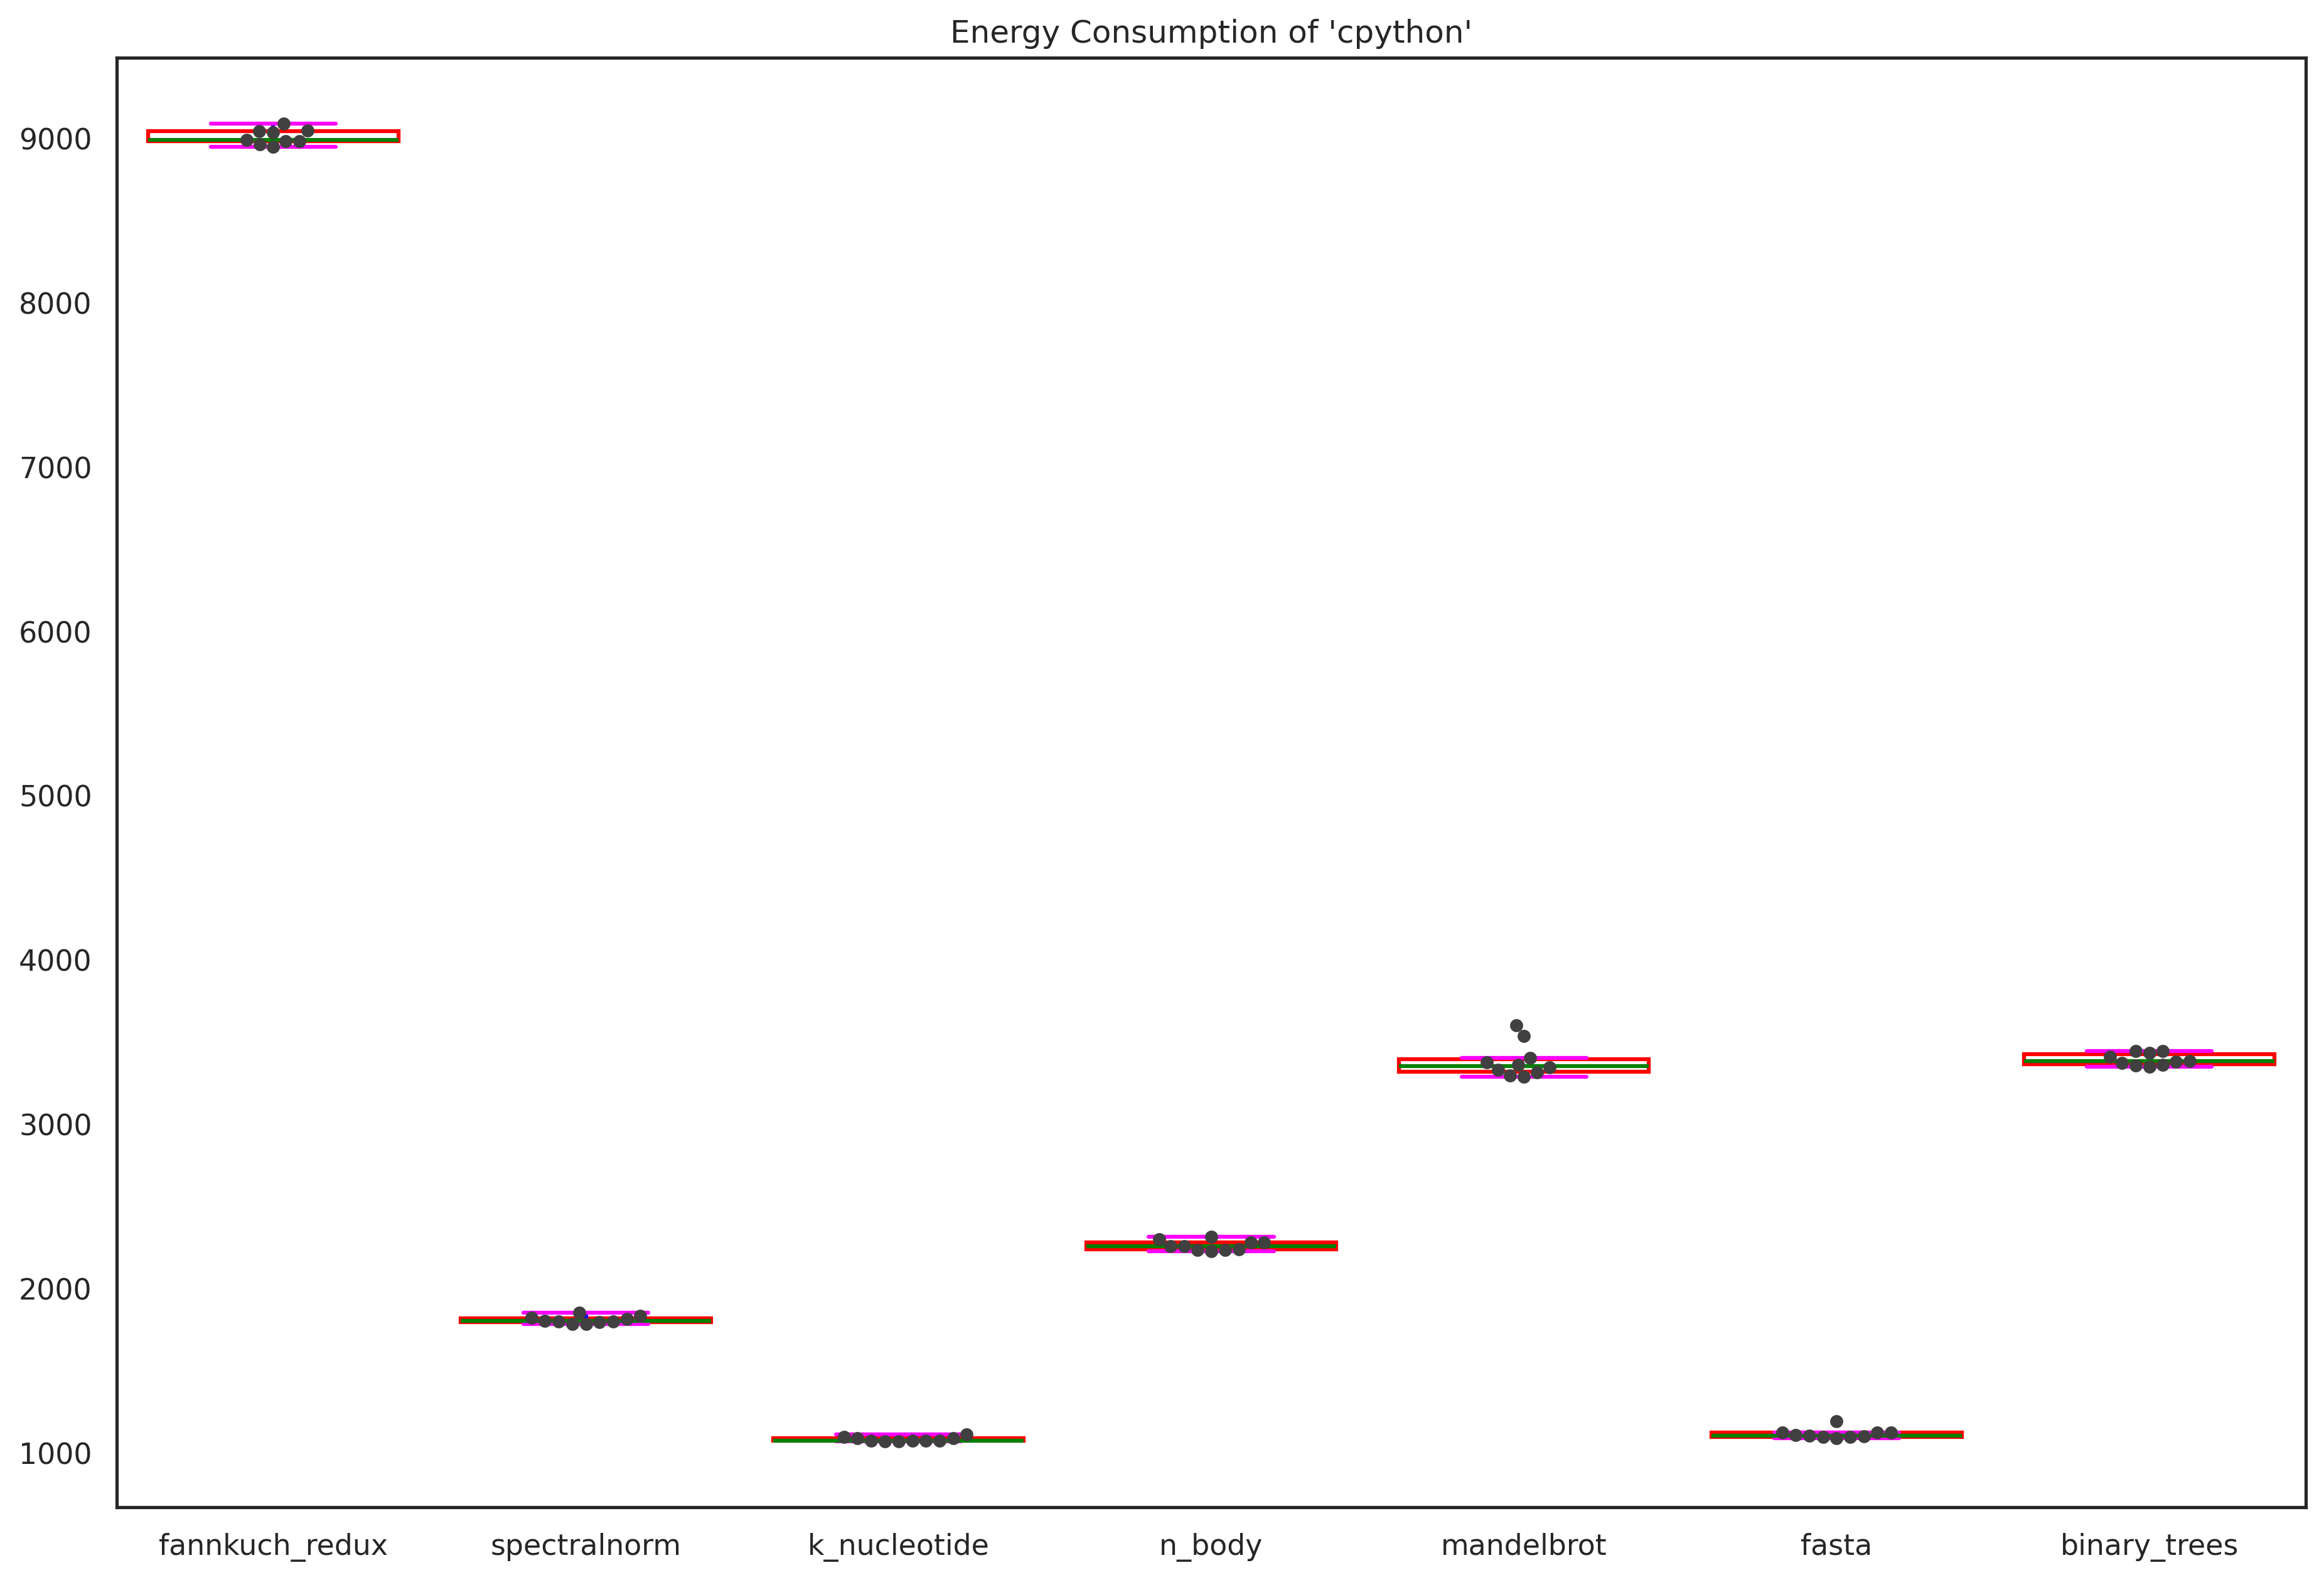

In [7]:
sns.set_theme(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('white')

def show_boxplot(data, title, metric, x_label = "", y_label = "", store=False):
    fig, ax = plt.subplots(figsize=(15, 10))
    PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'red'},
        'medianprops':{'color':'green'},
        'whiskerprops':{'color':'blue'},
        'capprops':{'color':'magenta'}
    }

    sns.boxplot(x='target',y=metric,
                data=data,
                showfliers=False,
                linewidth=1.5,
                ax=ax,
                **PROPS)

    sns.swarmplot(x='target', y=metric,
                  data=data,
                  color=".25",
                  ax=ax)

    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if store:
        plt.savefig(
            f'{title}.png', dpi=300, bbox_inches='tight'
        )

    # Display the plot
    plt.show()

for subject in EXPERIMENT['subject'].unique():
    show_boxplot(data=EXPERIMENT[EXPERIMENT['subject'] == subject],
                title=f"Energy Consumption of '{subject}'",
                metric='PP0_ENERGY (J)')

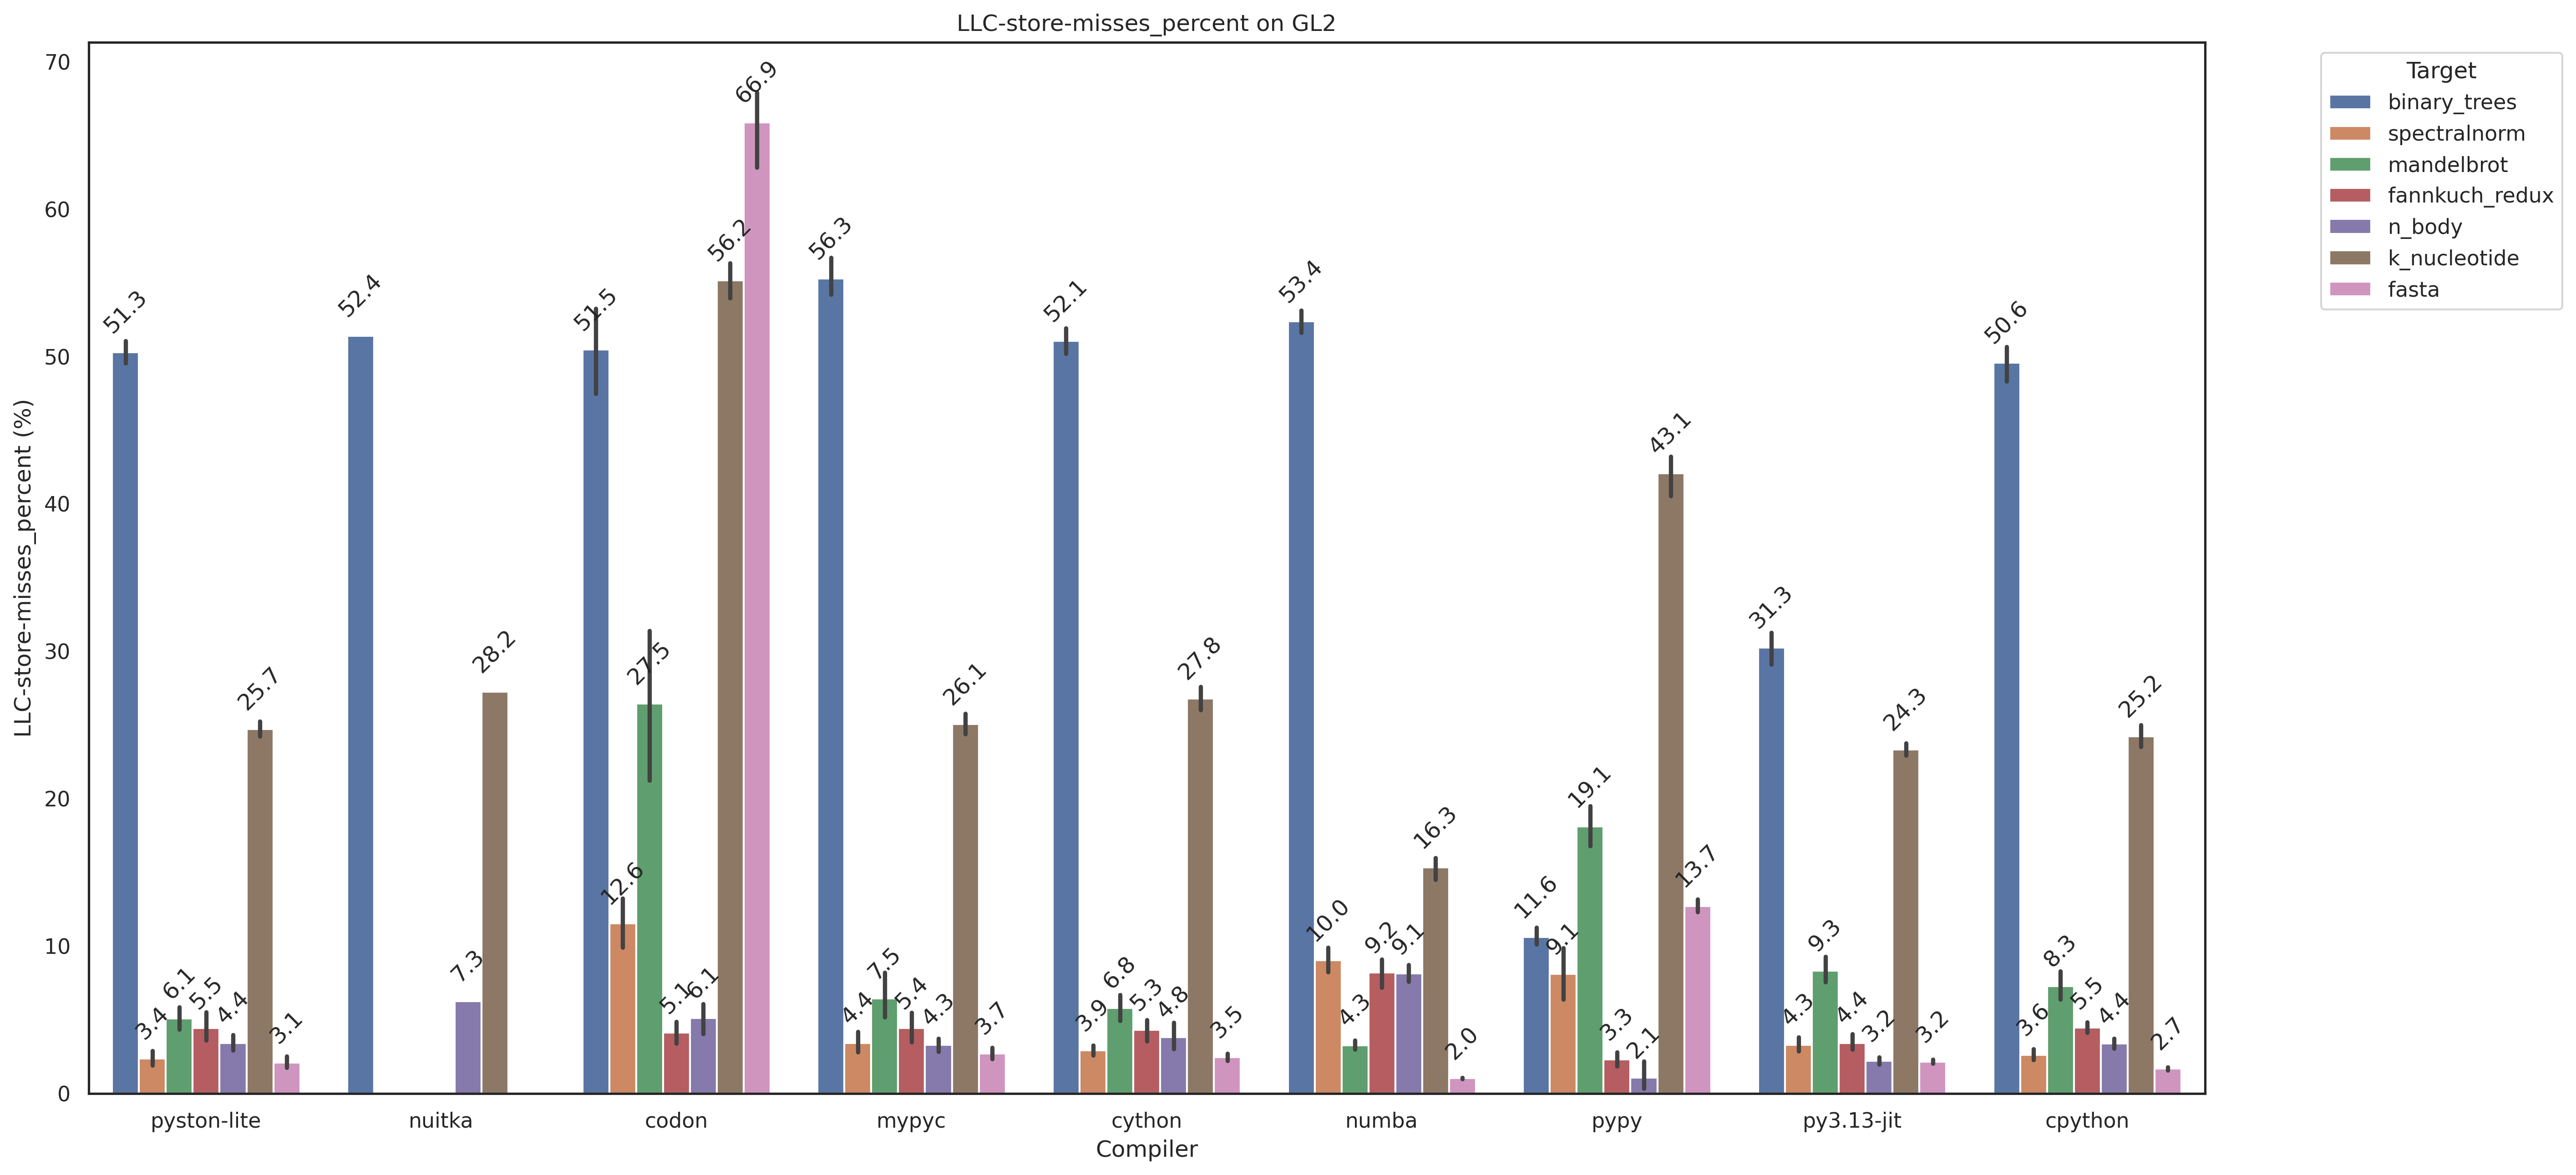

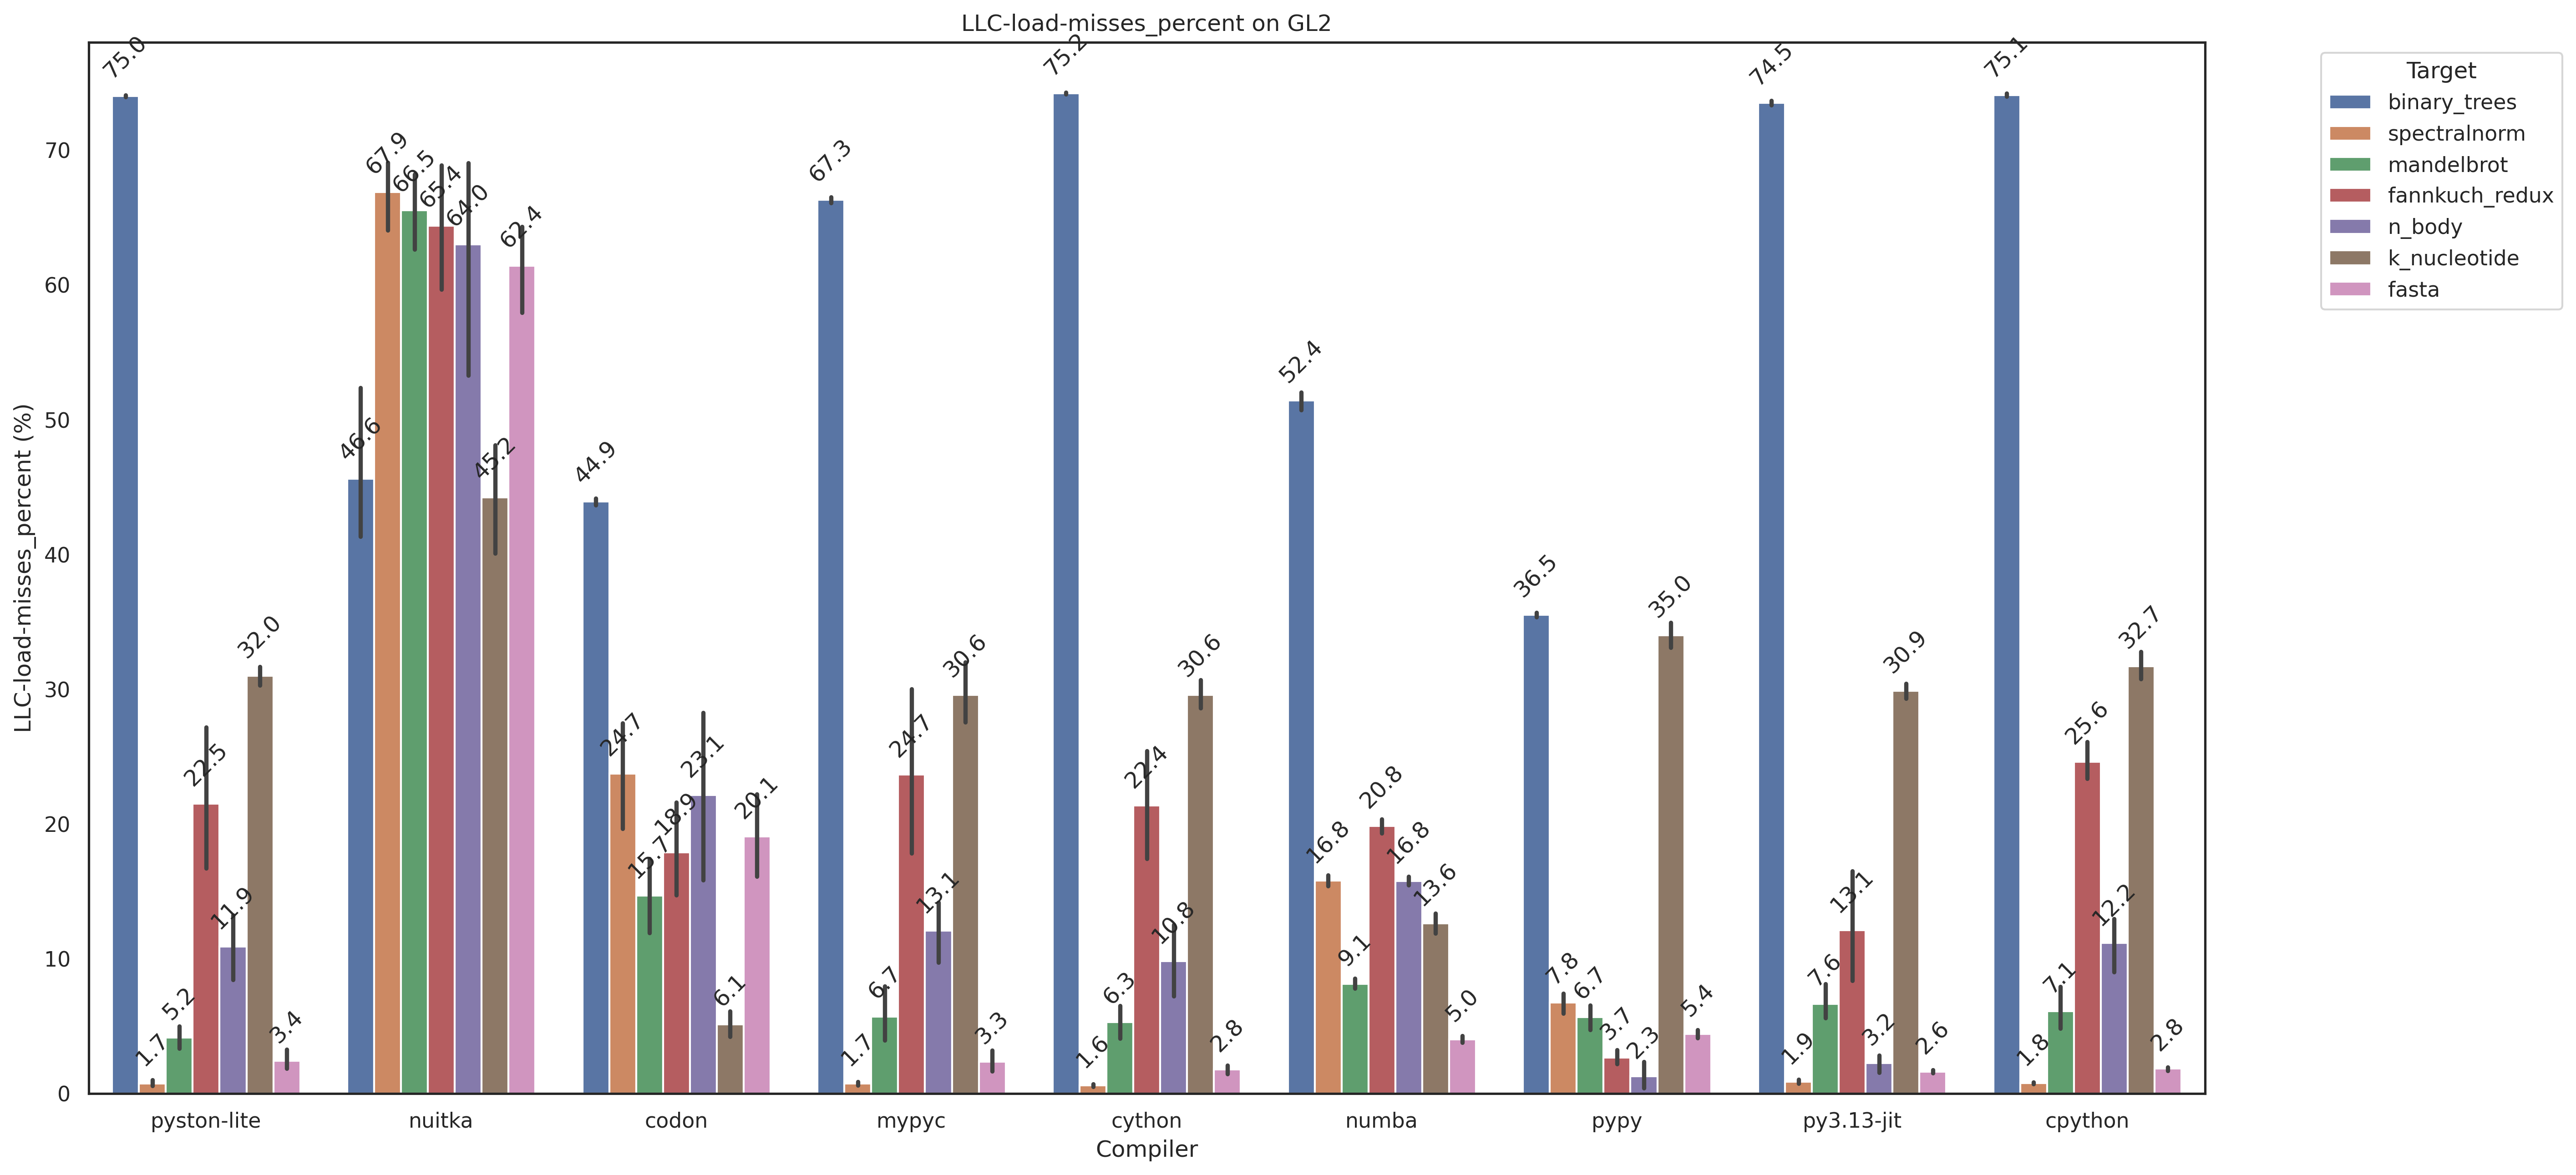

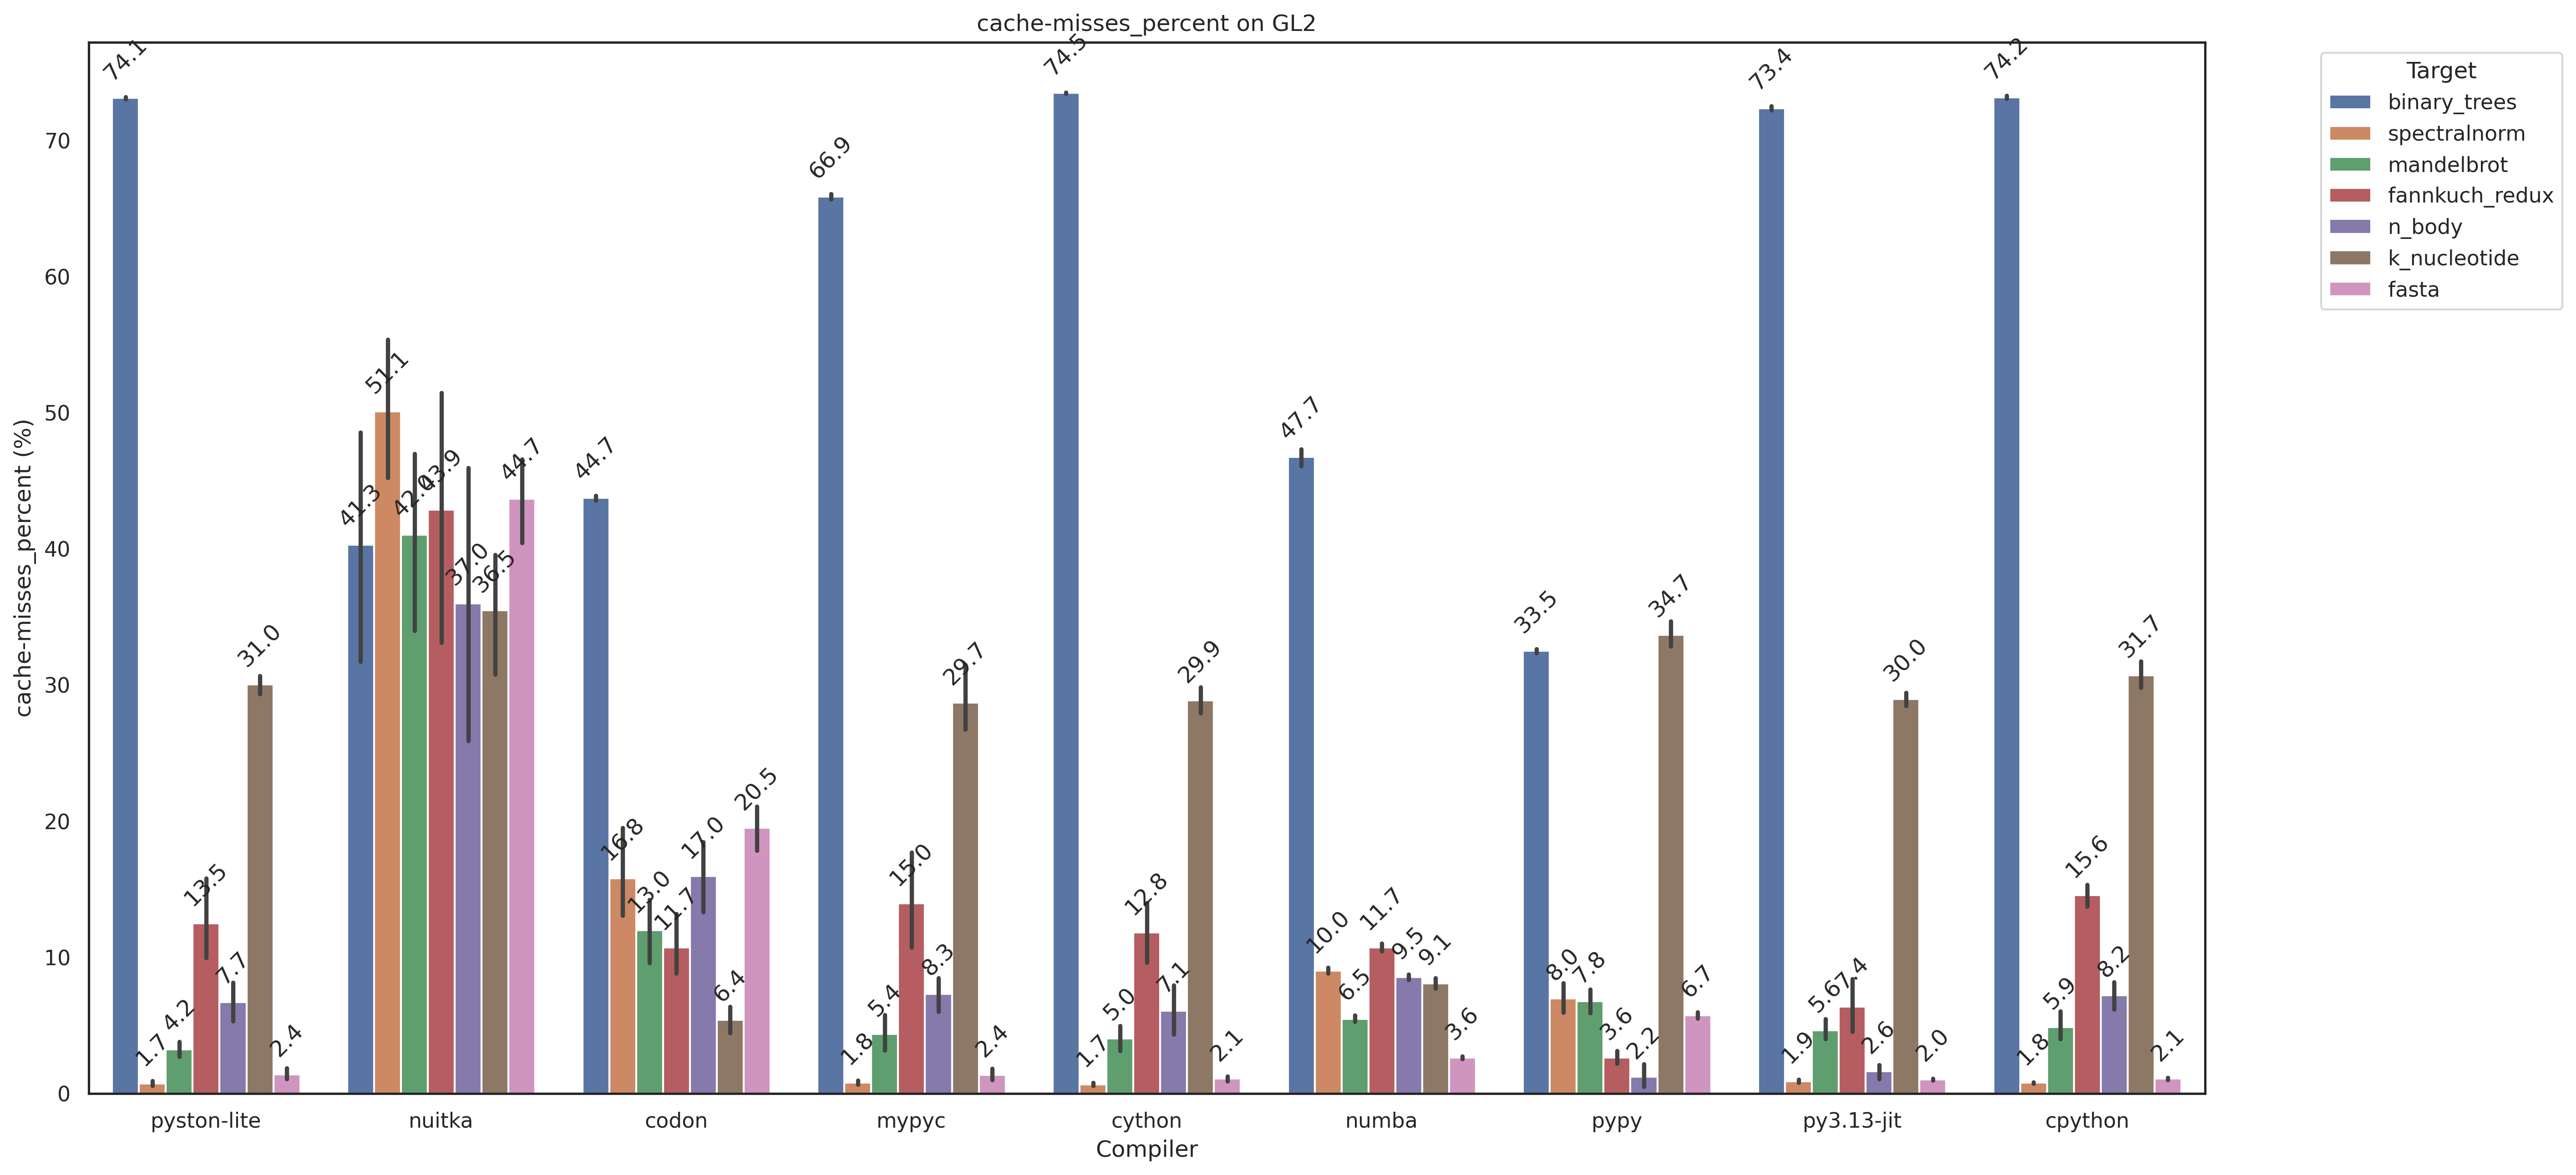

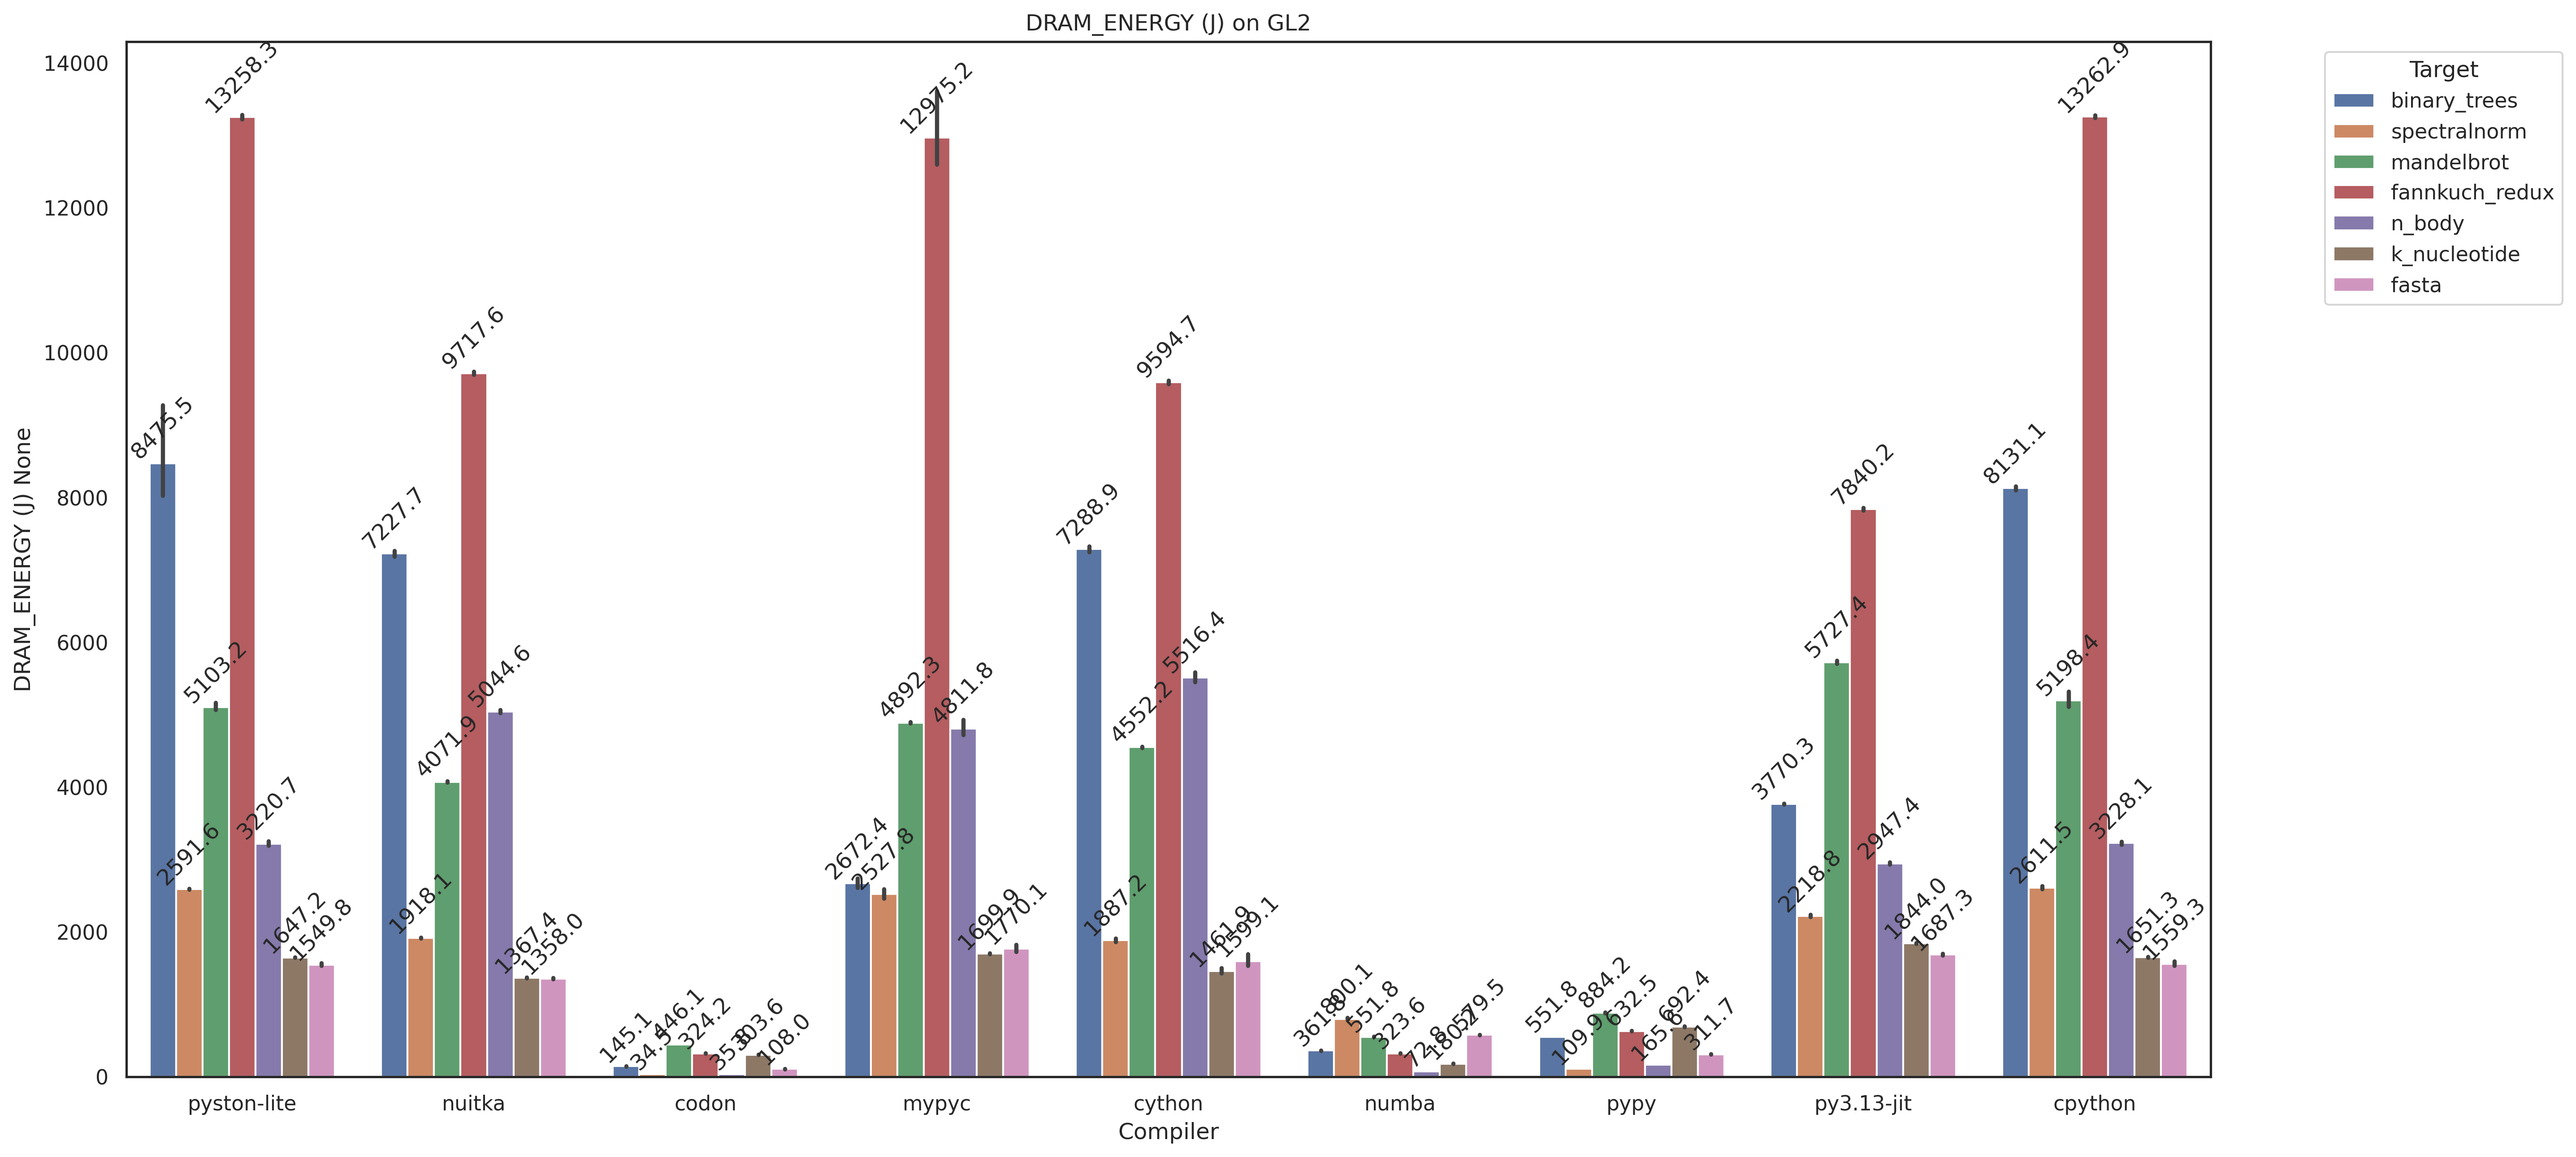

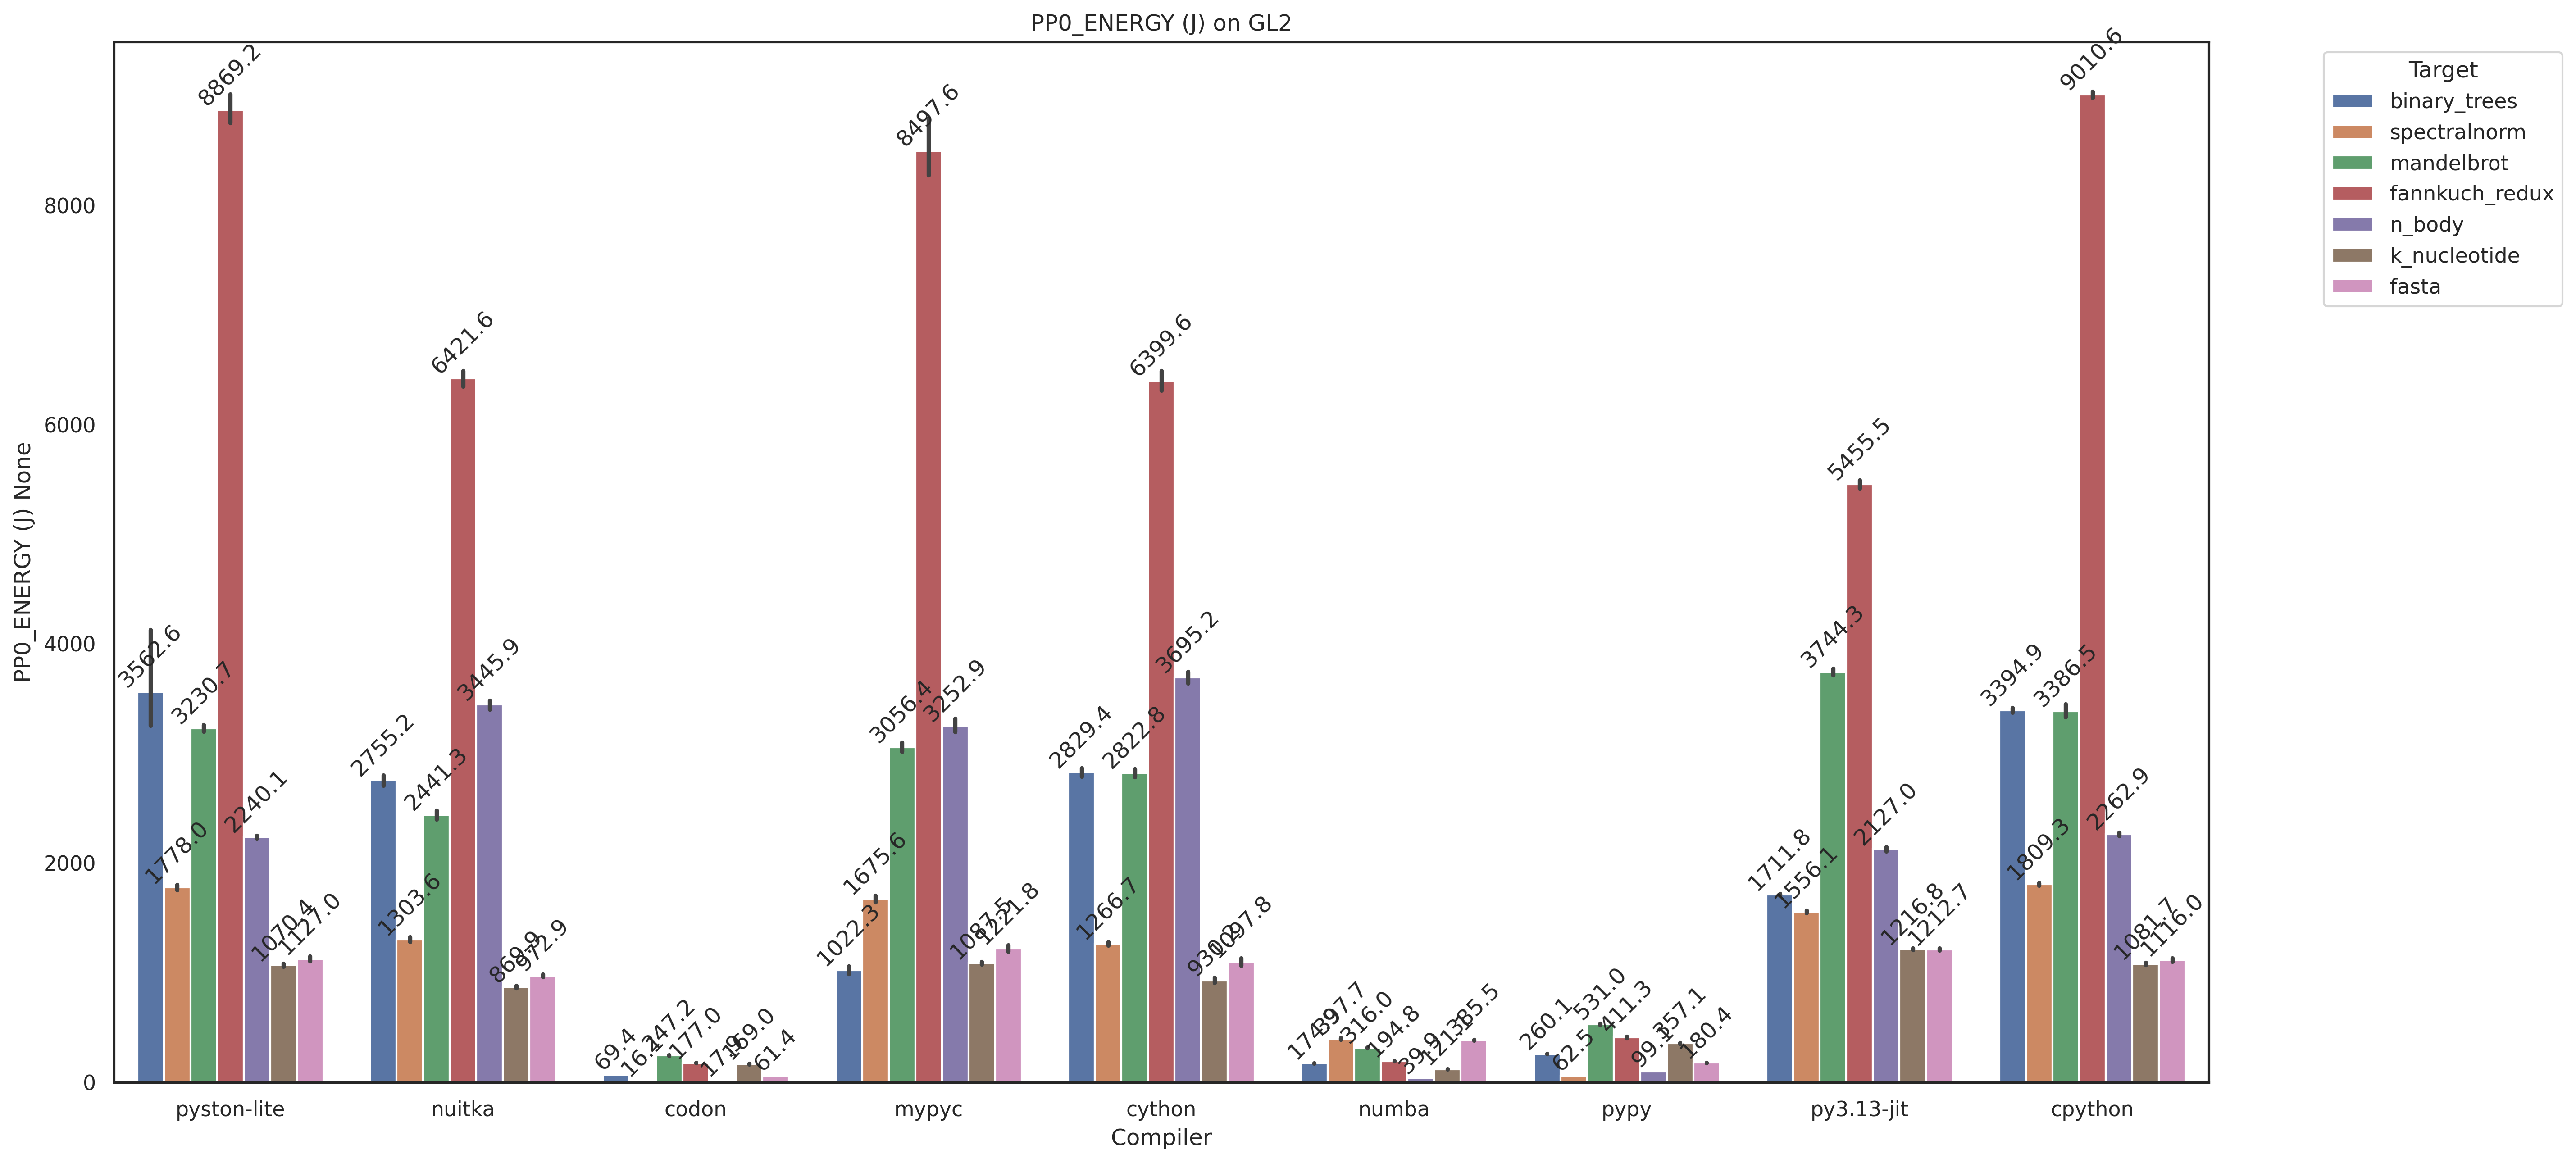

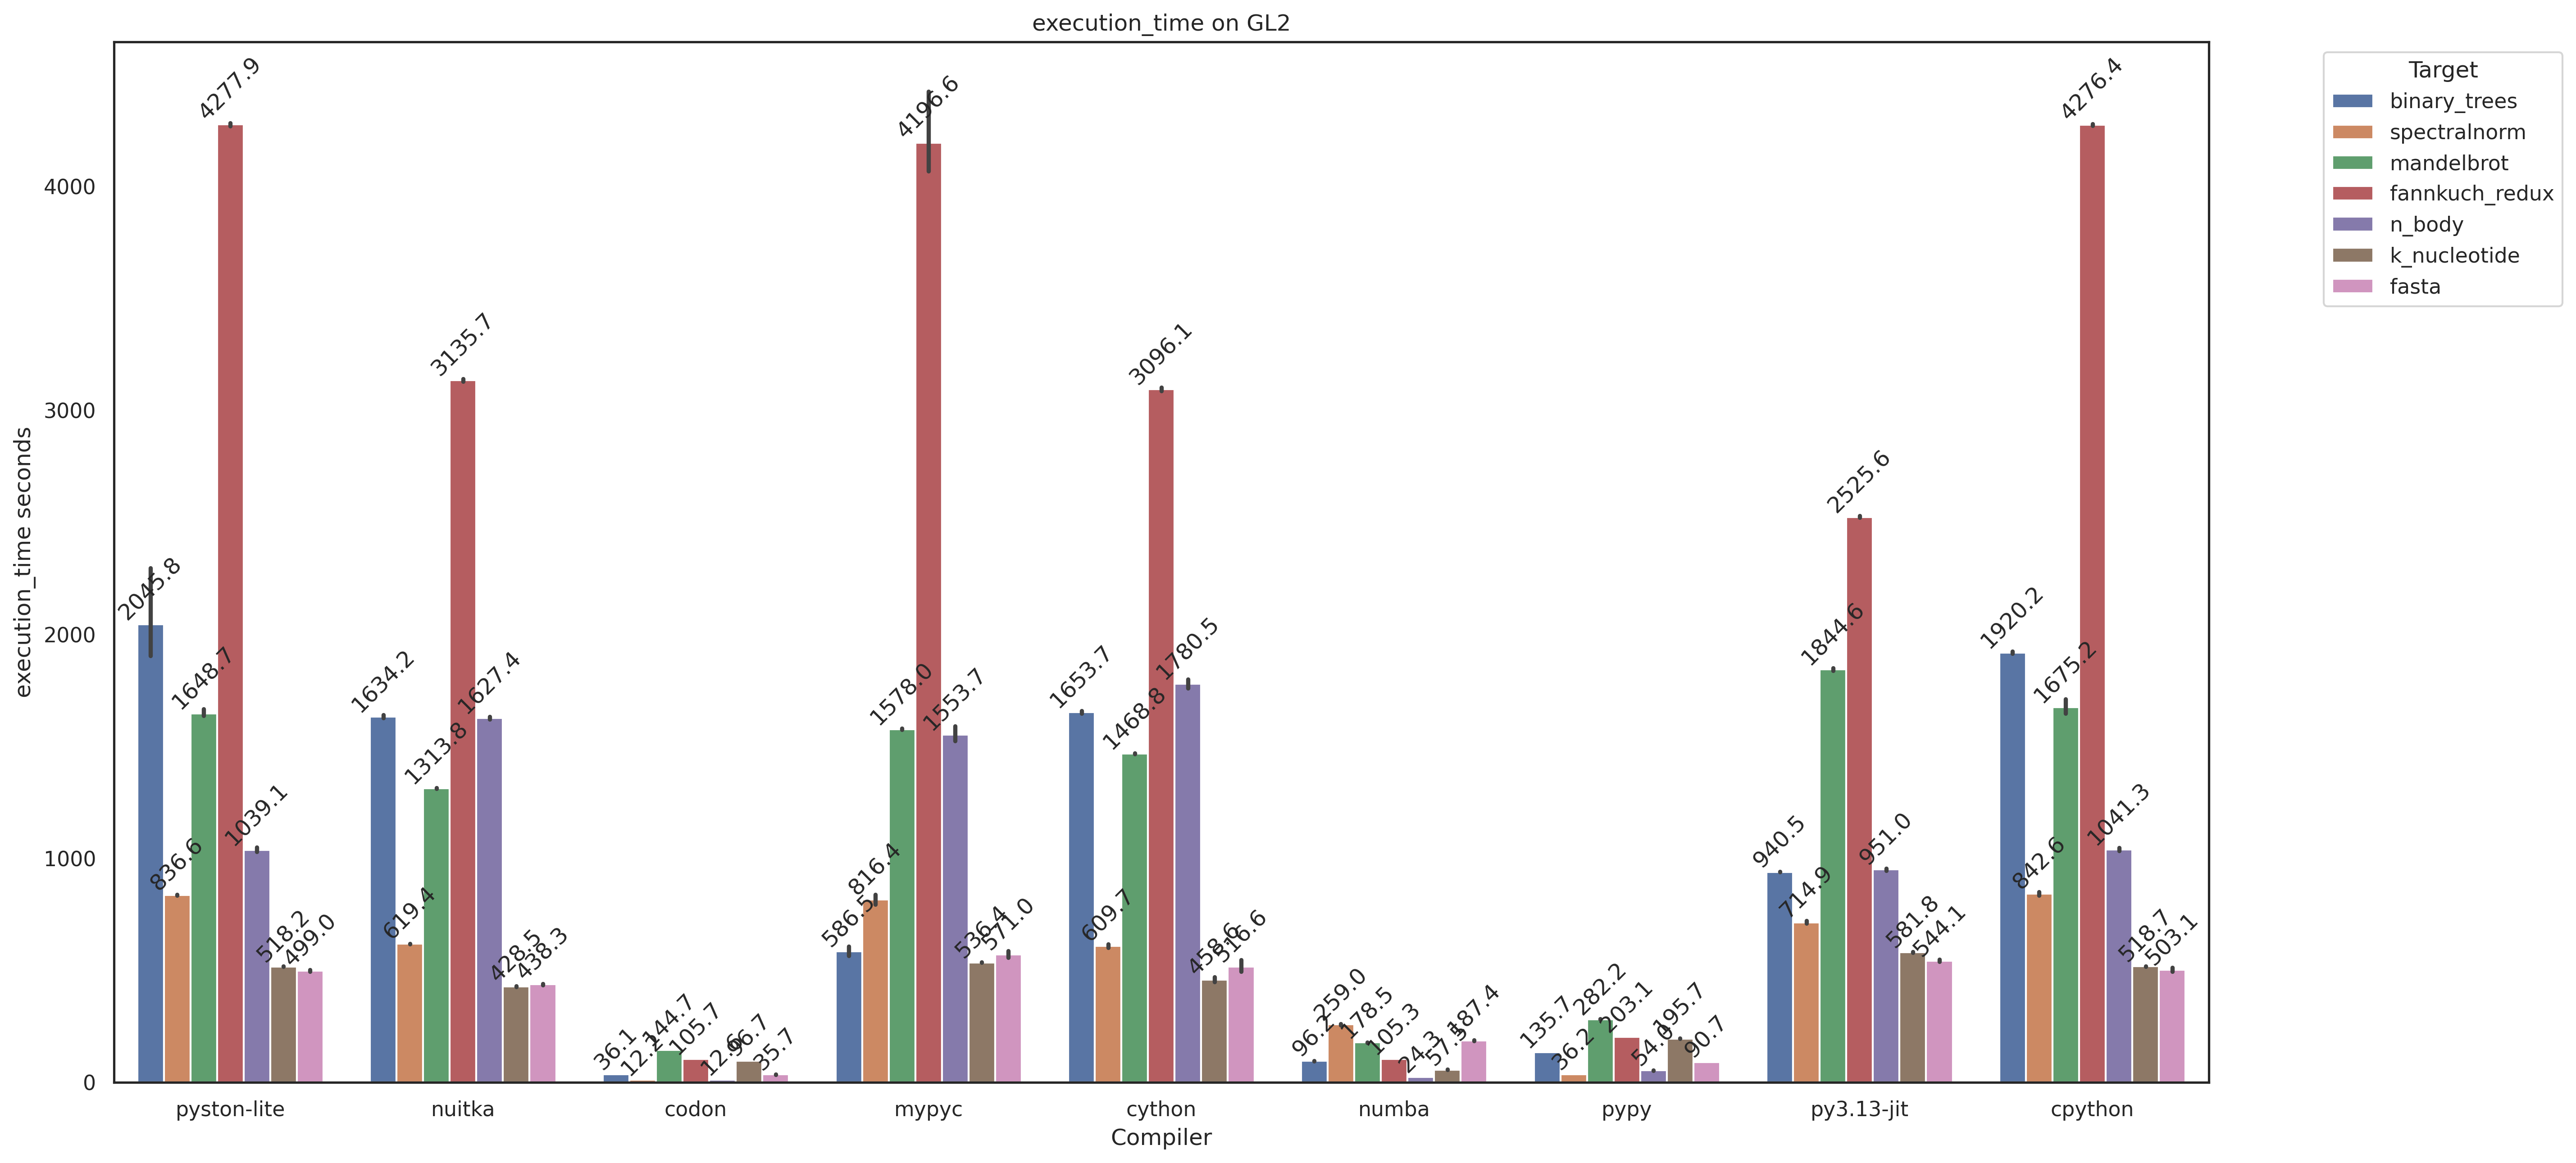

In [8]:
sns.set_theme(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('white')

def show_barchart(data, title, metric, x_label = "", y_label = "", store=False):
    fig, ax = plt.subplots(figsize=(20, 10))
    PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'red'},
        'medianprops':{'color':'green'},
        'whiskerprops':{'color':'blue'},
        'capprops':{'color':'magenta'}
    }

    sns.barplot(x='subject',y=metric,
                data=data,
                hue='target',
                estimator='mean', 
                #errorbar=None, # If you want to turn the errorbars off
                ax=ax)

    # Annotate means at the top of bars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height() + 1  # Get the height of the bar
            x = bar.get_x() + bar.get_width() / 2  # Center the text on the bar
            mean_text = f"{height:.1f}"  # Format the mean value
            ax.text(x, height, mean_text, ha='center', va='bottom', rotation=45)  # Add text at 45-degree angl

    # Customize the plot
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    ax.legend(title="Target", bbox_to_anchor=(1.05, 1), loc='upper left')

    if store:
        plt.savefig(
            f'{title}.png', dpi=300, bbox_inches='tight'
        )

    # Display the plot
    plt.show()

for metric in ['LLC-store-misses_percent', 'LLC-load-misses_percent', 'cache-misses_percent', 'DRAM_ENERGY (J)', 'PP0_ENERGY (J)', 'execution_time']:
    show_barchart(data=EXPERIMENT,
                title=f"{metric} on GL2",
                x_label='Compiler',
                y_label=f'''{metric} {f"{'(%)' if metric.endswith('percent') else 'seconds' if not metric.endswith('(J)') else None}"}''',
                metric=metric)